# Проект "Анализ причин оттока клиентов Gectaro - облачного сервиса для автоматизации управления строительством и ремонтом."

**Введение:**
Заказчиком является компания, развивающая облачный сервис для автоматизации управления строительством и ремонтом.  
Данная компания продает софт с платной подпиской в сегменте B2B, предназначенный для управления процессами в сфере строительства и ремонта.  
Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.



**Цель:** Проанализировать имеющиеся данные, составить портреты наиболее типичных клиентов, разобраться в причинах оттока клиентов, предложить решения по их минимизации.

В распоряжении имеются следующие файды с описанием компаний-клиентов и их сотрудников:

1. Файл активностей (activities.csv) - датасет следующей структуры:
   * Company_id - Идентификатор компании,
   * Month - Отчетный месяц,
   * Company-month-billing - Количество счетов, выставленных в приложении, компанией за месяц,
   * Company-month-stocks - Месячное количество складов (аренда, заказы и т.д.), используемых компанией,
   * Company-month-backups - Месячное количество бэкапов компании,
   * Company-month-projects - Месячное количество проектов компании,
   * Company-month-contractors - Месячное количество контрагентов компании,
   * Company-month-resource_orders - Месячное количество заказов материалов компании.

  
2. Файл платежей (billing.csv) - датасет следующей структуры:
   * Unnamed:0 - Старый индекс,
   * User_id - Идентификатор пользователя,
   * Company_id - Идентификатор компании пользователя,
   * Billing_tariff_id - Тарифный план,
   * Payed_until - Дата, до которой подписка компании действует,
   * Is_payed - Статус оплаты,
   * Created_at - Дата создания,
   * Updated_at - Дата обновления,
   * Billing_tariff_price_id - id стоимости тарифа,
   * Comment - Комментарии,
   * Pay_date - Дата платежа.


3. Файл компаний (companies.csv) - датасет следующей структуры:
   * Id - id компании,
   * Working_direction - сфера деятельности,
   * Employer_count_interval - id количества сотрудников,
   * Created_at - дата создания компании в системе,
   * Updated_at - дата обновления информации о компании,
   * Billing_tariff_id - id тарифа, 
   * Billing_is_over - истекла ли оплата.


4. Файл сотрудников (people.csv)  - датасет следующей структуры:
   * Id - индекс,
   * Company_id - id компании,
   * User_id - id пользователя,
   * Role_id - id роли (должности),
   * Created_at - дата создания пользователя,
   * Updated_at - дата обновления информации о пользователе,
   * Is_deleted - удален ли пользователь,
   * Deleted_at - дата удаления.

По информации заказчика, поле "Статус оплаты"  не является достоверным признаком ухода по непродлению оплаты, поскольку на момент формирования датасета компания могла себе продлить подписку на будущее, но оплата еще не прошла.

План исследования:
1.  Загрузка данных подготовка их к анализу.
    * Загрузка данных.
    * Изучение и предобработка данных.
        * Преобразование названий столбцов (в snake_case, при необходимости).
        * Преобразование данных в нужные типы (при необходимости). 
        * Обработка пропущенных значений: 
            * решение о целесообразности работы с пропусками в зависимости от доли пропущенных значений в столбце, 
            * исследование пропусков в столбце(столбцах) с большой долей пропусков, определение природы их возникновения, категории пропуска(MCAR, MAR,MNAR), принятие решения по возможности их корректного заполнения.
            * Проверка на наличие дубликатов(явных и неявных).
            * Проверка на наличие редких и выбивающихся значений.
2. Исследовательский анализ данных:
    * Определение отточных компаний.
    * Выявление признаков отточности.
    * Составление портретов уходящих клиентов.
    * Корреляционный анализ - составление матрицы корреляции признаков. Изучение и использование библиотеки phik.
3. Формулировка и проверка статистических гипотез.
4. Формирование общих выводов и рекомендаций для заказчика .    
5. Подготовка презентации.

**Результат:**

Проведен исследовательский анализ данных, определены признаки отточных клиентов.  Выявлены наиболее высокоотточные сегменты пользователей.  
Составлены портреты отточных и неотточных клиентов.
Сформированы рекомендации заказчику по улучшению качества данных и в части уменьшения доли отточных клиентов

## Загрузка данных подготовка их к анализу

### Загрузка данных.

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import math as mth
import phik
from ydata_profiling import ProfileReport

from datetime import date, datetime

from scipy import stats as st
from statistics import mode

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

%matplotlib inline

Загрузим данные и изучим основную информацию о них.

In [2]:
people = pd.read_csv("...")

billing = pd.read_csv("...")

activities = pd.read_csv("...")

companies = pd.read_csv("...")

Установим стандартные размер графиков и подписей.

In [3]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.rc('font', size=12) 
plt.rc('axes', titlesize=13) 
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('legend', fontsize=12) 


### Объявление фунций, необходимых для проведения анализа

#### Функция отображения общей информации о датафрейме

In [4]:
def inform (data, dict_1 = None):
    '''Данная функция принимает в качестве аргумента датафрейм и выводит основную информацию о каждом из его столбцов:
    * наименование столбца, его описание на русском языке(в случае, если вторым аргументом в функцию передан 
    словарь содержащий необходимую информацию);
    * тип данных;
    * информацию о наличии пропусков и выбросов.
    '''
    if dict_1 == None:
        dict_1 = {}
    print(f'Количество строк в датафрейме: {data.shape[0]}\n\nИнформация о столбцах датафрейма:\n')
    n = 1
    for column in data.columns:
        print(n,')',sep = '', end = ' ')
        try:
            print(f'Столбец "{column}" - {dict_1[column]}:')
        except:
            print(f'Столбец "{column}":')
        print(f'Тип данных: {data[column].dtype}')
        print(f'Количество уникальных значений: {data[column].nunique()}.')
        if data[column].isna().sum() == 0:
            print('Пропуски отсутствуют.')
        else: 
            print(f'Количество пропусков в столбце: {data[column].isna().sum()} ({data[column].isna().sum()/len(data):.2%}).')
        try:
            q1,q3 = data[column].quantile(0.25), data[column].quantile(0.75)
            iqr = q3 - q1
            data1 = data.loc[(data[column] < (q3 + 1.5*iqr)) & (data[column] > (q1 - 1.5*iqr))]
            length = len(data1)+data[column].isna().sum()
            if length == len(data):
                print('Выбросы отсутствуют.')
            else:
                print(f'Количество выбросов в столбце: {len(data) - length} ({(len(data) - length)/len(data):.2%}).')
        except:
            pass
        print('-'*45)
        n+=1

#### Функция визуализации корреляции

In [5]:
def correlations(data, phik = False, lim = 0):
    '''Данная функция принимает в качестве аргумента датафрейм и визуализирует корреляцию столбцов датафрейма с столбцом "is churn"(отток)
    В зависимости от значения второго аргумента строится корреляция Пирсона(phik = False - по умолчанию), либо корреляция методом Phik(phik = True)/
    Также имеестя возможность установить нижнюю границу значений корреляции, подлежащих визуализации, изменив параметр "lim".
    '''
    if phik == True:
        data_corr= data.phik_matrix()
        plt.figure(figsize=(6,10))
        sns.heatmap(data_corr.loc[data_corr['churn'] > lim, ['churn']].drop('churn').sort_values('churn',key=abs,ascending = False),
                    annot=True, vmin=-1, vmax=1, center= 0, linewidths=0.5)
    else:
        data_corr= data.corr()
        plt.figure(figsize=(6,10))
        sns.heatmap(data_corr.loc[abs(data_corr['churn']) > lim, ['churn']].drop('churn').sort_values('churn', ascending = False),
                    annot=True, vmin=-1, vmax=1, center= 0, linewidths=0.5)
        plt.show();

#### Функция визуализации распределения признаков в зависимости от оттока

In [6]:
def group_visual(data, column, column_g = 'churn', bins = 50):
    ''' Данная функция принимает в качестве аргументов датафрейм  и названия 2 его столбцов и строит визуализацию распределения
    значений столбца "column" c группировкой в зависимости от значений столбца "column_g".'''
    title_name = {'month_count': 'количества месяцев активности',
                  'billing': 'среднемесячного количества счетов, выставленных компанией за месяц',
                  'stocks': 'среднемесячного количества складов, используемых компанией',
                  'backups': 'среднемесячного количества бэкапов компании',
                  'projects': 'среднемесячного количества проектов компании',
                  'contractors': 'среднемесячного количества контрагентов компании',
                  'resource_orders': 'среднемесячного количества заказов материалов компании',
                  'count_employees': 'количества сотрудников',
                  'tariffs_groups': 'группы тарифов',
                  'payed_until': 'даты, до которой подписка компании действует',
                  'is_payed': 'статуса оплаты',
                  'created_at': 'даты создания',
                  'updated_at': 'даты обновления',
                  'billing_tariff_price_id': 'id стоимости тарифа',
                  'total_month' : 'длительности пользования сервисом',
                  'payed_ratio': 'доли оплаченных подписок',
                  'month_act_ratio': 'среднемесячной активности пользователей'}
    x_name = {'month_count': 'Количество месяцев активности',
              'billing': 'Среднемесячное количество счетов, выставленных компанией за месяц',
              'stocks': 'Среднемесячное количество складов, используемых компанией',
              'backups': 'Среднемесячное количество бэкапов компании',
              'projects': 'Среднемесячное количество проектов компании',
              'contractors': 'Среднемесячное количество контрагентов компании',
              'resource_orders': 'Среднемесячное количество заказов материалов компании',
              'count_employees': 'Количество сотрудников',
              'tariffs_groups': 'Группа тарифов',
              'payed_until': 'Дата, до которой подписка компании действует',
              'is_payed': 'Статус оплаты',
              'created_at': 'Дата создания',
              'updated_at': 'Дата обновления',
              'billing_tariff_price_id': 'Id стоимости тарифа',
              'total_month' :'Длительность пользования сервисом, месяцев',
              'payed_ratio': 'Доли оплаченных подписок',
              'month_act_ratio': 'Cреднемесячная активность пользователей'}

    y_line = data[column_g].mean()
    if data[column].nunique() > 15:
        sns.histplot(data=data, x=column, hue=column_g, bins=bins, stat='density', common_norm=False, kde=True)
        plt.title(f'Распределение оттока компаний в зависимости от {title_name[column]}')
        plt.xlabel(f'{x_name[column]}')
        plt.ylabel('Плотность')
        plt.show()
    else:
        sns.barplot(x=column, y=column_g, data=data.groupby(column)[column_g].mean().reset_index())
        plt.title(f'Доля отточных компаний в зависимости от {title_name[column]}')
        plt.axhline(y = y_line, color = 'b', linestyle = '--', label = "В среднем по сервису")
        plt.xlabel(f'{x_name[column]}')
        plt.ylabel('Доля')
        plt.legend()
        plt.show()

#### Функция рассчета доли отточных клиентов в срезе, удовлетворяющем переданному условию.

In [7]:
def churn_group(df, criterion):
    '''Функция принимает в качестве аргументов датафрейм и условие в виде строки, и формирует информацию, о количестве пользователей, 
    удовлетворяющих данному условию, доле оттока, и общем количестве пользователей в датафрейме'''
    df_slice = df.query(f'{criterion}').groupby('company_id').churn.first().reset_index()
    df_results = pd.DataFrame(df_slice .agg({"churn":'mean','company_id':'nunique'}).values,
                     index=['Отток','Размер сегмента']).T
    df_results['Размер сегмента'] = df_results['Размер сегмента'].astype(int)
    df_results['Общее количество пользователей в данных'] = df.company_id.nunique()
    return df_results

### Изучение и предобработка данных

#### Изучение и предобработка данных в датасете "companies"(информация о компаниях)

Выведем общую информацию о данных.

In [8]:
companies.head()

,Unnamed: 0,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,19,514,-,1.0,1571316635,1670298314,4.0,True
1,57,383,Строительство,2.0,1564142565,1676550050,7.0,False
2,69,495,-,1.0,1570535695,1598281714,2.0,False
3,75,724,-,1.0,1579514393,1670298294,4.0,True
4,99,471,-,1.0,1569328017,1670298360,7.0,True


In [9]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               723 non-null    int64  
 1   id                       723 non-null    int64  
 2   working_direction        720 non-null    object 
 3   employer_count_interval  723 non-null    float64
 4   created_at               723 non-null    int64  
 5   updated_at               723 non-null    int64  
 6   billing_tariff_id        716 non-null    float64
 7   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), int64(4), object(1)
memory usage: 40.4+ KB


In [10]:
inform(companies)

Количество строк в датафрейме: 723

Информация о столбцах датафрейма:

1) Столбец "Unnamed: 0":
Тип данных: int64
Количество уникальных значений: 723.
Пропуски отсутствуют.
Количество выбросов в столбце: 2 (0.28%).
---------------------------------------------
2) Столбец "id":
Тип данных: int64
Количество уникальных значений: 723.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
3) Столбец "working_direction":
Тип данных: object
Количество уникальных значений: 170.
Количество пропусков в столбце: 3 (0.41%).
---------------------------------------------
4) Столбец "employer_count_interval":
Тип данных: float64
Количество уникальных значений: 8.
Пропуски отсутствуют.
Количество выбросов в столбце: 32 (4.43%).
---------------------------------------------
5) Столбец "created_at":
Тип данных: int64
Количество уникальных значений: 723.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
6) Столбец "updated_at":
Тип

 Переименуем столбец с ID компании для удобства дальнейшего анализа.

In [11]:
companies.rename(columns = {'id': 'company_id'}, inplace=True)

Преобразуем тип данных в столбцах с датой. 

In [12]:
for i in ['created_at', 'updated_at']:
    companies[i] = pd.to_datetime(companies[i], unit='s').dt.date

В столбце с ID  тарифа имеются пропущенные значения. Изучим данные подробнее.

In [13]:
companies.query('billing_tariff_id.isna()')

,Unnamed: 0,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
70,1311,1394,ремонты,2.0,2020-07-06,2020-07-06,NaN,False
122,2207,2366,-,1.0,2020-11-17,2020-11-17,NaN,False
615,8311,7478,-,1.0,2023-03-06,2023-03-06,NaN,False
616,8313,7479,-,1.0,2023-03-07,2023-03-07,NaN,False
617,8315,7480,-,1.0,2023-03-07,2023-03-07,NaN,False
618,8317,7481,-,1.0,2023-03-07,2023-03-07,NaN,False
642,8885,7944,-,1.0,2023-05-15,2023-05-15,NaN,False


Четыре из семи этих компаний заведены в систему 6-7 марта 2023 года. Кроме того, информация о них в системе не обновлялась.  
Возможно отрицательное значение в столбце "billing_is_over" вызвано тем, что данные компании не стали клиентами сервиса и оплата произведена не была. 
Проверим наличие информации о этих компаниях в других датасетах.

In [14]:
companies_list2 = companies.query('billing_tariff_id.isna()')['company_id'].to_list()
companies_list2

[1394, 2366, 7478, 7479, 7480, 7481, 7944]

In [15]:
activities.query('company_id in @companies_list2').company_id.count()

0

In [16]:
billing.query('company_id in @companies_list2').company_id.count()

0

In [17]:
people.query('company_id in @companies_list2').company_id.count()

6

In [18]:
people.query('company_id in @companies_list2')

,Unnamed: 0,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
492,1929,2038,1394,751.0,1,1594046968,1594046968,False,NaN
3755,13110,17903,7478,10027.0,1,1678133266,1678133266,False,NaN
3757,13112,17904,7479,10029.0,1,1678174074,1678174074,False,NaN
3758,13113,17905,7480,10030.0,1,1678174873,1678174873,False,NaN
3759,13114,17906,7481,10031.0,1,1678175908,1678175908,False,NaN
4086,13977,18743,7944,10676.0,1,1684149633,1684149633,False,NaN


Информация о 6 из этих компаний имеется только в данных о сотрудниках(по одному сотруднику на каждую компанию).
Для сопоставления даты внесения информации о пользователях и компании, также переведем в коректный тип данных и столбы с датой в датасете "people".

In [19]:
for i in ['created_at', 'updated_at', 'deleted_at']:
    people[i] = pd.to_datetime(people[i], unit='s').dt.date

In [20]:
people.query('company_id in @companies_list2')

,Unnamed: 0,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
492,1929,2038,1394,751.0,1,2020-07-06,2020-07-06,False,NaT
3755,13110,17903,7478,10027.0,1,2023-03-06,2023-03-06,False,NaT
3757,13112,17904,7479,10029.0,1,2023-03-07,2023-03-07,False,NaT
3758,13113,17905,7480,10030.0,1,2023-03-07,2023-03-07,False,NaT
3759,13114,17906,7481,10031.0,1,2023-03-07,2023-03-07,False,NaT
4086,13977,18743,7944,10676.0,1,2023-05-15,2023-05-15,False,NaT


Даты внесения информации о пользователях и компаниях совпадают. Информация о этих компаниях была внесена однократно и в последующем не обновлялась.  
Данные компании по всей видимости клиентами сервиса не стали и интереса для исседования эти строки не представляют, поэтому их можно удалить.

In [21]:
companies.dropna(subset=['billing_tariff_id'], inplace=True)

In [22]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 0 to 722
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               716 non-null    int64  
 1   company_id               716 non-null    int64  
 2   working_direction        713 non-null    object 
 3   employer_count_interval  716 non-null    float64
 4   created_at               716 non-null    object 
 5   updated_at               716 non-null    object 
 6   billing_tariff_id        716 non-null    float64
 7   billing_is_over          716 non-null    bool   
dtypes: bool(1), float64(2), int64(2), object(3)
memory usage: 45.4+ KB


Преобразуем в целочисленный формат данные в столбцах с ID тарифа и ID количества сотрудников.

In [23]:
companies = companies.astype({'employer_count_interval':int, 'billing_tariff_id':int})

In [24]:
companies.employer_count_interval.value_counts()

employer_count_interval
1    492
2    146
3     46
4     14
5      9
8      4
7      3
6      2
Name: count, dtype: int64

Компаний с ID количества сотрудников от 4 до 8 крайне мало. Рассматривать отток по группе с таким количеством компаний будет малоинформативно. 
Поэтому объеденим их в одну группу.

Объявим функции, преобразования ID тарифа и ID количества сотрудников  в соответствующие группы.

In [25]:
def create_tariffs_groups(cell):
    '''Функция присваивает группы по айди тарифа клиента'''
    if cell in [4, 7, 8, 11, 19]:
        return 'Старт'
    elif cell in  [2, 17]:
        return 'Базовый'
    elif cell in [9, 20]:
        return 'Бизнес'
    elif cell in [3, 10, 13, 21]:
        return 'Профи'
    elif cell == 6:
        return 'Архивный'
    else:
        return 'тариф не определен'

In [26]:
def count_employees(cell):
    if cell==1:
        return "до_4"
    elif cell==2:
        return "от_5_до_10"
    elif cell==3:
        return "от_11_до_20"
    elif cell> 3:
        return "более_20"
    else:
        return "некорректное значение"

Добавим в датасет столбцы с группой тарифа и группой по количеству сотрудников.

In [27]:
companies['count_employees'] = companies['employer_count_interval'].map(count_employees)
companies['tariffs_groups'] = companies['billing_tariff_id'].map(create_tariffs_groups)

Проверим корректность формирования столбцов.

In [28]:
companies.tariffs_groups.value_counts()

tariffs_groups
Базовый     330
Старт       306
Бизнес       51
Профи        23
Архивный      6
Name: count, dtype: int64

In [29]:
companies.count_employees.value_counts()

count_employees
до_4           492
от_5_до_10     146
от_11_до_20     46
более_20        32
Name: count, dtype: int64

Столбцы сформированы корректно. 

Визуализируем полученный результат

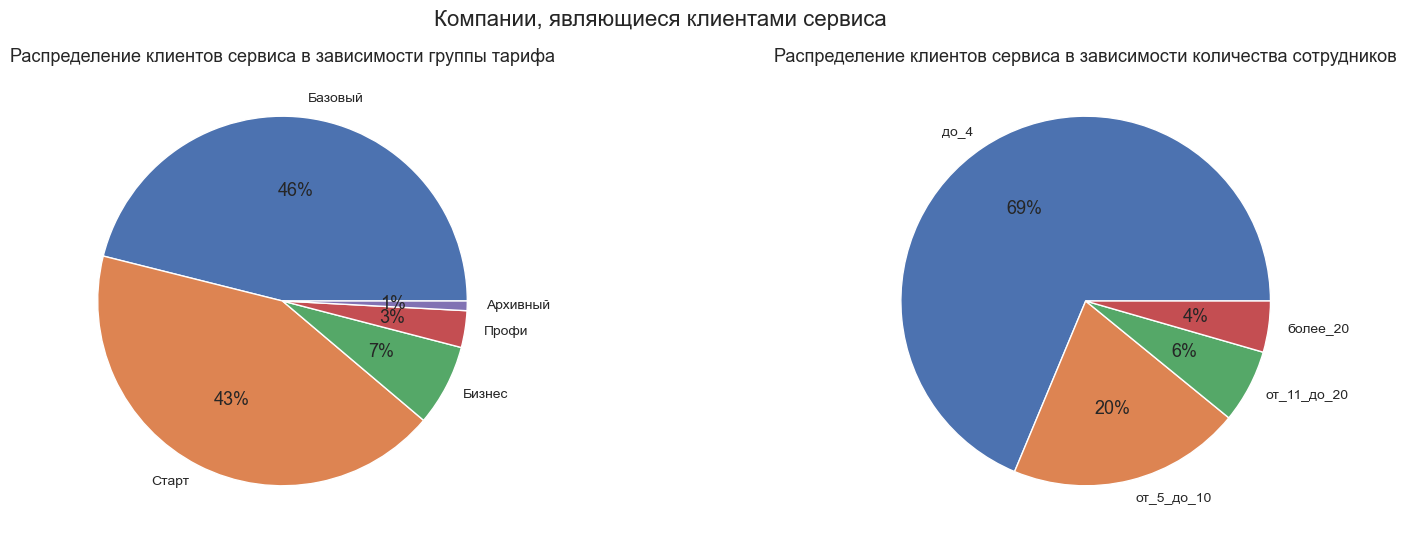

In [30]:
companies_tariff = companies.groupby('tariffs_groups').company_id.count().sort_values(ascending = False).reset_index()
companies_employees = (companies.groupby('count_employees').company_id.count().sort_values(ascending = False).reset_index())

plt.figure(figsize=(19,6))
plt.suptitle(f'Компании, являющиеся клиентами сервиса', fontsize=16)
plt.rcParams['font.size'] = 13.0

plt.subplot(1, 2, 1)
plt.pie(companies_tariff['company_id'], labels= companies_tariff['tariffs_groups'], autopct='%.0f%%')
plt.title(f'Распределение клиентов сервиса в зависимости группы тарифа')

plt.subplot(1, 2, 2)
plt.pie(companies_employees['company_id'], labels= companies_employees['count_employees'], autopct='%.0f%%')
plt.title(f'Распределение клиентов сервиса в зависимости количества сотрудников')
plt.show()

**Вывод:** Основными клиентами сервиса являются пользователи групп тарифов "Базовый"(46%) и "Старт"(43%).
Практически 90% клиентов относятся к малым компаниям. У 69% компаний в штате до 4 сотрудников, у 20% - от 5 до 10.  

Изучим  уникальные значения в столбце с сферой деятельности компании, а также количество уникальных значений.

In [31]:
companies.working_direction.nunique()

169

In [32]:
for i in companies[:200].working_direction.sort_values().unique(): #  уникальные значения по первым 200 строкам
    print(i)

-
-Малоэтажное строительство
Генеральный подрядчик
Девелопмент
Демонтажные работы
Дизайн интерьеров
Изготовление заборов
Малоэтажное строительство
Малоэтажное строительство 
Отделка
Отделка 
Проектирование и строительство ресторанов 
Проектирование,  Производство и Строительство
Ремонт и отделка помещений
Ремонт квартир
Ремонт под ключ
Ремонт помещений
Ремонтно-строительная 
Ремонтные работы
СТРОИТЕЛЬСТВО
Строительная компания
Строительно-монтажные работы
Строительство
Строительство домов
Строительство загородных домов
Строительство и ремонт
Строительство каркасных домов
Строительство коттеджей
Строительство рыбоводных ферм
Электромонтаж
Электромонтажные работы
Электроэнергетика 
ремонт
ремонт и отделка
строительная компания (тест)
строительство
строительство 
строительство  и отделка
телемаркетинг
nan


По всей видимости клиенты компании заполняют данную информацию самостоятельно. Ввиду большого количества пропусков, прочерков, ошибок в данных, а также различных вариантов написания, преобразование и группировка значений по данному столбцу достаточно трудоемка и вероятнее всего нецелесообразна. В данном исследовании информацию из столбца исследовать не будем.
Необходимо рекомендовать заказчику унифицировать варианты внесенния информацию в столбце с сферой деятельности. 

Удалим из датафрейма столбцы, не представляющие интереса для дальнейшего исследования.

In [33]:
companies.drop(['Unnamed: 0', 'working_direction','employer_count_interval'],axis = 1, inplace=True) #, 'updated_at'
companies

,company_id,created_at,updated_at,billing_tariff_id,billing_is_over,count_employees,tariffs_groups
0,514,2019-10-17,2022-12-06,4,True,до_4,Старт
1,383,2019-07-26,2023-02-16,7,False,от_5_до_10,Старт
2,495,2019-10-08,2020-08-24,2,False,до_4,Базовый
3,724,2020-01-20,2022-12-06,4,True,до_4,Старт
4,471,2019-09-24,2022-12-06,7,True,до_4,Старт
...,...,...,...,...,...,...,...
718,7074,2022-12-20,2024-02-28,7,True,до_4,Старт
719,6279,2022-06-27,2024-03-05,2,True,от_11_до_20,Базовый
720,6256,2022-06-21,2024-03-07,7,True,до_4,Старт
721,5411,2022-02-16,2024-03-12,9,False,до_4,Бизнес


In [34]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 0 to 722
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   company_id         716 non-null    int64 
 1   created_at         716 non-null    object
 2   updated_at         716 non-null    object
 3   billing_tariff_id  716 non-null    int32 
 4   billing_is_over    716 non-null    bool  
 5   count_employees    716 non-null    object
 6   tariffs_groups     716 non-null    object
dtypes: bool(1), int32(1), int64(1), object(4)
memory usage: 37.1+ KB


Уточним максимальную и минимальную дату в столбцах.

Так как данную операцию будем производить неоднократно, объявим соответствующую функцию.

In [35]:
def min_max_date(column):
    ''' Функция принимает столбец с даннымми в формате даты и выводит минимальное и максимальное его значение'''
    print(f'Минимальная дата, представленная в столбце: {column.min()}',
          f'Максимальная дата, представленная в столбце: {column.max()}', sep = '\n')

In [36]:
min_max_date(companies.created_at)

Минимальная дата, представленная в столбце: 2019-01-23
Максимальная дата, представленная в столбце: 2024-02-07


In [37]:
min_max_date(companies.updated_at)

Минимальная дата, представленная в столбце: 2020-08-24
Максимальная дата, представленная в столбце: 2024-03-13


В данных представлена информация о компаниях, зарегистрированных в сервисе начиная с января 2019 года.

Сохраним перечень ID компаний для последующего исследования.

In [38]:
companies_list = companies['company_id'].to_list()

**Вывод:** Данные подготовлены для анализа. Проработаны пропуски, удалены столбцы, не представляющие интереса для анализа, откорректирован тип данных в столбцах.  
Необходимо рекомендовать заказчику унифицировать варианты внесенния информацию в столбце с сферой деятельности. 

#### Изучение и предобработка данных в датасете "billing"(информация о платежах)

Изучим основную информацию о данных.

In [39]:
billing.head()

,Unnamed: 0.1,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
0,4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
1,6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09
2,16,16,3059,1902,1645,2,1616577484,False,1608801484,1608801484,6.0,NaN,NaN
3,18,18,3065,2352,2035,7,1643500799,False,1608883175,1608883175,23.0,NaN,NaN
4,24,24,3062,1074,926,3,1611964800,True,1608814072,1608899674,9.0,NaN,1.609200e+09


In [40]:
billing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0.1             3480 non-null   int64  
 1   Unnamed: 0               3480 non-null   int64  
 2   id                       3480 non-null   int64  
 3   user_id                  3480 non-null   int64  
 4   company_id               3480 non-null   int64  
 5   billing_tariff_id        3480 non-null   int64  
 6   payed_until              3480 non-null   int64  
 7   is_payed                 3480 non-null   bool   
 8   created_at               3480 non-null   int64  
 9   updated_at               3480 non-null   int64  
 10  billing_tariff_price_id  3480 non-null   float64
 11  comment                  745 non-null    object 
 12  pay_date                 1108 non-null   float64
dtypes: bool(1), float64(2), int64(9), object(1)
memory usage: 329.8+ KB


In [41]:
inform(billing)

Количество строк в датафрейме: 3480

Информация о столбцах датафрейма:

1) Столбец "Unnamed: 0.1":
Тип данных: int64
Количество уникальных значений: 3480.
Пропуски отсутствуют.
Количество выбросов в столбце: 2 (0.06%).
---------------------------------------------
2) Столбец "Unnamed: 0":
Тип данных: int64
Количество уникальных значений: 3480.
Пропуски отсутствуют.
Количество выбросов в столбце: 2 (0.06%).
---------------------------------------------
3) Столбец "id":
Тип данных: int64
Количество уникальных значений: 3480.
Пропуски отсутствуют.
Количество выбросов в столбце: 1 (0.03%).
---------------------------------------------
4) Столбец "user_id":
Тип данных: int64
Количество уникальных значений: 1841.
Пропуски отсутствуют.
Количество выбросов в столбце: 3 (0.09%).
---------------------------------------------
5) Столбец "company_id":
Тип данных: int64
Количество уникальных значений: 1841.
Пропуски отсутствуют.
Количество выбросов в столбце: 3 (0.09%).
----------------------------

Изучим информацию, находящуюся в столбце с комментариями.

In [42]:
for i in billing.comment.sort_values().unique()[:20]: # 20 уникальныx значений
    print(i)

 + 2 недели теста, Грант сказал, что договорились с пользователем так (было до 25,04)
 12+1  Запрос на заморозку 07 11 2022  осталось 343 дня
 30,05 активация 12+2
 ожидается 2 части оплаты, 4 мес в подарок (24 месяца + 4)
25,10.21 - 58800
 оказалось, что это не партнер, а клиент от партнера. Доступ забрала, пере открыла стартовый
(24 месяцев) + 120дн
(24 месяцев) + 120дн
16,08 - частичная оплата 22 тыс
25 07 2022 +3 месяца за отзыв
+ 2 мес в подарок, попал под акцию
+2 мес
+2мес в подарок
+3 мес за кейс с 12 04.2022
+30 дней в подарок
01,03,24 - тест на неделю тарифа выше
07,03,24- отключили тариф и поменяли обратно на стартовый (был до 30,08,24
01,04,21 - запросили возврат (срок был 6 мес по 12,02,22)
01,06,23 - 24+4
20,09,23 - попросили заморозить (было 743 дня до 02,10,2025)
01,08,2023 - активация 12+1
01,08,23- 12+1
01,10,20 - сделали возврат, закрыли тариф (был до 9,12,20)
01,12 - активировали пакет стартовый на 3 мес
02,02 - клиенту было предложено +1 мес в подарок в связи с нед

Информация в столбце разнородная и требующая больших усилий для обработки.  
В данном исследовании использовать ее нецелесообразно.

Удалим из данных столбцы, не представляющие интереса для исследований.

In [43]:
billing.drop(['Unnamed: 0', 'comment','Unnamed: 0.1'],axis = 1, inplace=True)

А также приведем столбцы с датой в корректный тип данных. И уточним минимальную и максимальную дату в этих столбцах

In [44]:
for i in ['payed_until', 'created_at', 'pay_date','updated_at']:
    billing[i] = pd.to_datetime(billing[i], unit='s').dt.date


In [45]:
for i in ['payed_until', 'created_at','updated_at']:
    print(f'Столбец "{i}"')
    min_max_date(billing[i])
    print()

Столбец "payed_until"
Минимальная дата, представленная в столбце: 2019-09-11
Максимальная дата, представленная в столбце: 2033-04-10

Столбец "created_at"
Минимальная дата, представленная в столбце: 2019-07-23
Максимальная дата, представленная в столбце: 2024-03-13

Столбец "updated_at"
Минимальная дата, представленная в столбце: 2019-07-23
Максимальная дата, представленная в столбце: 2024-03-13



В столбце с датой окончания подписки максимальной датой является '2033-04-10'. Исходя из того, что большинство подписок по техническому заданию формируется на 1-2 года, это значение является аномально большим.
Однако, говорить о некорректности данного значения нельзя, возможно это клиент, для которого предусмотрены уникальные условия, тестовый аккаунт или т.п. 

Переведем значение в столбце с ID стоимости тарифа в целочисленный формат.

In [46]:
billing['billing_tariff_price_id'] = billing['billing_tariff_price_id'].astype(int)

Так как в данных имеется информация о компаниях, отстутствующих в других датасетах, информацию о них сохраним в отдельную переменную, для возможной их обработки в последующем, а в исходном датасете оставим только данные о компаниях, фигурирующих во всех из представленных датасетах.

In [47]:
billing_nc = billing.query('company_id not in @companies_list')

In [48]:
billing = billing.query('company_id in @companies_list')

В столбце с датой оплаты имеются пропуски. Возможно они связаны с фактом произведенной оплаты(с значением в столбце "is_payed").
Проверим, есть ли строки с произведенной оплатой, но пропуском в столбце с датой оплаты. И наоборот, без оплаты, но проставленной датой оплаты.

In [49]:
billing.query('is_payed and pay_date.isna()').head(3)

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,pay_date
102,2487,2290,1975,7,2021-01-31,True,2020-10-16,2021-01-18,21,NaT
308,2963,2748,2391,3,2022-01-03,True,2020-12-03,2021-03-25,12,NaT
408,1868,1093,943,7,2021-02-04,True,2020-08-04,2020-08-04,22,NaT


In [50]:
billing.query('not is_payed and pay_date.notna()').head(3)

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,pay_date
15,3057,2920,2507,4,2021-06-23,False,2020-12-23,2020-12-23,15,2020-12-25
35,4176,4007,3323,7,2021-12-28,False,2021-05-19,2021-06-11,22,2021-05-19
115,4539,711,628,4,2021-07-26,False,2021-06-23,2021-06-23,13,2021-06-25


Пропуски в столбце с датой оплаты не связаны с фактом оплаты.   
Часть пропусков можно было бы обосновать отсутствием оплаты подписки. Часть же вероятнее всего вызвана вшеним фактором, техническим сбоем или человеческим фактором при внесении информации.

Проверим данные на наличие дубликатов.

In [51]:
billing.duplicated().sum()

0

Дубликаты отсутствуют.

**Вывод:** Данные подготовлены для анализа. Проработаны пропуски, удалены столбцы, не представляющие интереса для аналиа, откорректирован тип данных в столбцах.  
Необходимо рекомендовать заказчику уточнить корректность внесения информации в столбец с датой оплаты и его взаимосвязь с статусом оплаты.

#### Изучение и предобработка данных в датасете "activities"(информация об активностях) 

Изучим основную информацию о данных.

In [52]:
activities.head()

,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


In [53]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     6316 non-null   int64  
 1   company_id                     6316 non-null   int64  
 2   month                          6316 non-null   object 
 3   company-month-billing          6316 non-null   float64
 4   company-month-stocks           6316 non-null   float64
 5   company-month-backups          6316 non-null   float64
 6   company-month-projects         6316 non-null   float64
 7   company-month-contractors      6316 non-null   float64
 8   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 444.2+ KB


In [54]:
inform(activities)

Количество строк в датафрейме: 6316

Информация о столбцах датафрейма:

1) Столбец "Unnamed: 0":
Тип данных: int64
Количество уникальных значений: 6316.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
2) Столбец "company_id":
Тип данных: int64
Количество уникальных значений: 716.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
3) Столбец "month":
Тип данных: object
Количество уникальных значений: 63.
Пропуски отсутствуют.
---------------------------------------------
4) Столбец "company-month-billing":
Тип данных: float64
Количество уникальных значений: 10.
Пропуски отсутствуют.
Количество выбросов в столбце: 137 (2.17%).
---------------------------------------------
5) Столбец "company-month-stocks":
Тип данных: float64
Количество уникальных значений: 101.
Пропуски отсутствуют.
Количество выбросов в столбце: 697 (11.04%).
---------------------------------------------
6) Столбец "company-month-backups":
Т

Переименуем названия столбцов на более удобные для исследования.

In [55]:
activities.rename(columns = {i: i.replace('company-month-','').replace('-', '_') for i in activities.columns}, inplace = True)

In [56]:
activities.head()

,Unnamed: 0,company_id,month,billing,stocks,backups,projects,contractors,resource_orders
0,0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


Переведем данные в столбцах в целочисленный формат.

In [57]:
activities = activities.astype({'billing':int,
                              'stocks':int,
                              'backups':int,
                              'projects':int,
                              'contractors':int,
                              'resource_orders':int})

Откорректируем тип данных в столбце с датой.

In [58]:
activities['month'] = pd.to_datetime(activities['month']).dt.date

Проверим данные на наличие дубликатов.

In [59]:
activities.duplicated().sum()

0

Удалим столбец, не представляющий интереса для исследования.

In [60]:
del activities['Unnamed: 0']

Проанализируем распределение данных об активностях клиентов сервиса.

In [61]:
activities.describe()

,company_id,billing,stocks,backups,projects,contractors,resource_orders
count,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000
mean,4280.338505,0.375079,7.408486,1.178277,7.262666,7.906428,10.346105
std,2413.005439,0.800281,13.107824,3.135253,13.899203,27.966199,40.569956
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2459.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,4112.000000,0.000000,3.000000,0.000000,2.000000,2.000000,0.000000
75%,6080.000000,1.000000,8.000000,0.000000,7.000000,7.000000,4.000000
max,9931.000000,16.000000,166.000000,22.000000,221.000000,1014.000000,1182.000000


Визуально оценим строик с максимальными значениями в столбцах "stocks", "projects", "contractors", а также категории компаний по численности сотрудников, в строках с активностью которых замечены максимальные значения.

In [62]:
activities.merge(companies[['company_id','count_employees']], on = 'company_id').sort_values('stocks', ascending=False).head()

,company_id,month,billing,stocks,backups,projects,contractors,resource_orders,count_employees
952,1330,2020-07-01,0,166,7,166,74,0,до_4
2625,3623,2021-10-01,0,150,11,84,20,3,от_11_до_20
3868,5050,2022-06-01,0,129,0,155,0,2,до_4
2629,3623,2022-02-01,0,115,10,81,215,90,от_11_до_20
1405,2227,2021-10-01,0,112,0,116,0,2,до_4


In [63]:
activities.merge(companies[['company_id','count_employees']], on = 'company_id').sort_values('contractors', ascending=False).head()

,company_id,month,billing,stocks,backups,projects,contractors,resource_orders,count_employees
4507,5790,2023-11-01,0,2,0,1,1014,142,от_5_до_10
5613,7423,2023-03-01,2,0,0,1,847,5,более_20
2820,3674,2021-07-01,3,5,0,3,767,5,до_4
6229,9243,2023-12-01,0,73,0,8,536,1,до_4
5487,7211,2023-07-01,0,2,0,2,369,151,более_20


In [64]:
activities.merge(companies[['company_id','count_employees']], on = 'company_id').sort_values('projects', ascending=False).head()

,company_id,month,billing,stocks,backups,projects,contractors,resource_orders,count_employees
2547,3518,2023-04-01,0,30,0,221,15,21,от_5_до_10
2769,3654,2024-01-01,0,41,0,212,81,140,от_5_до_10
1149,1645,2022-02-01,0,5,0,207,5,3,до_4
952,1330,2020-07-01,0,166,7,166,74,0,до_4
3868,5050,2022-06-01,0,129,0,155,0,2,до_4


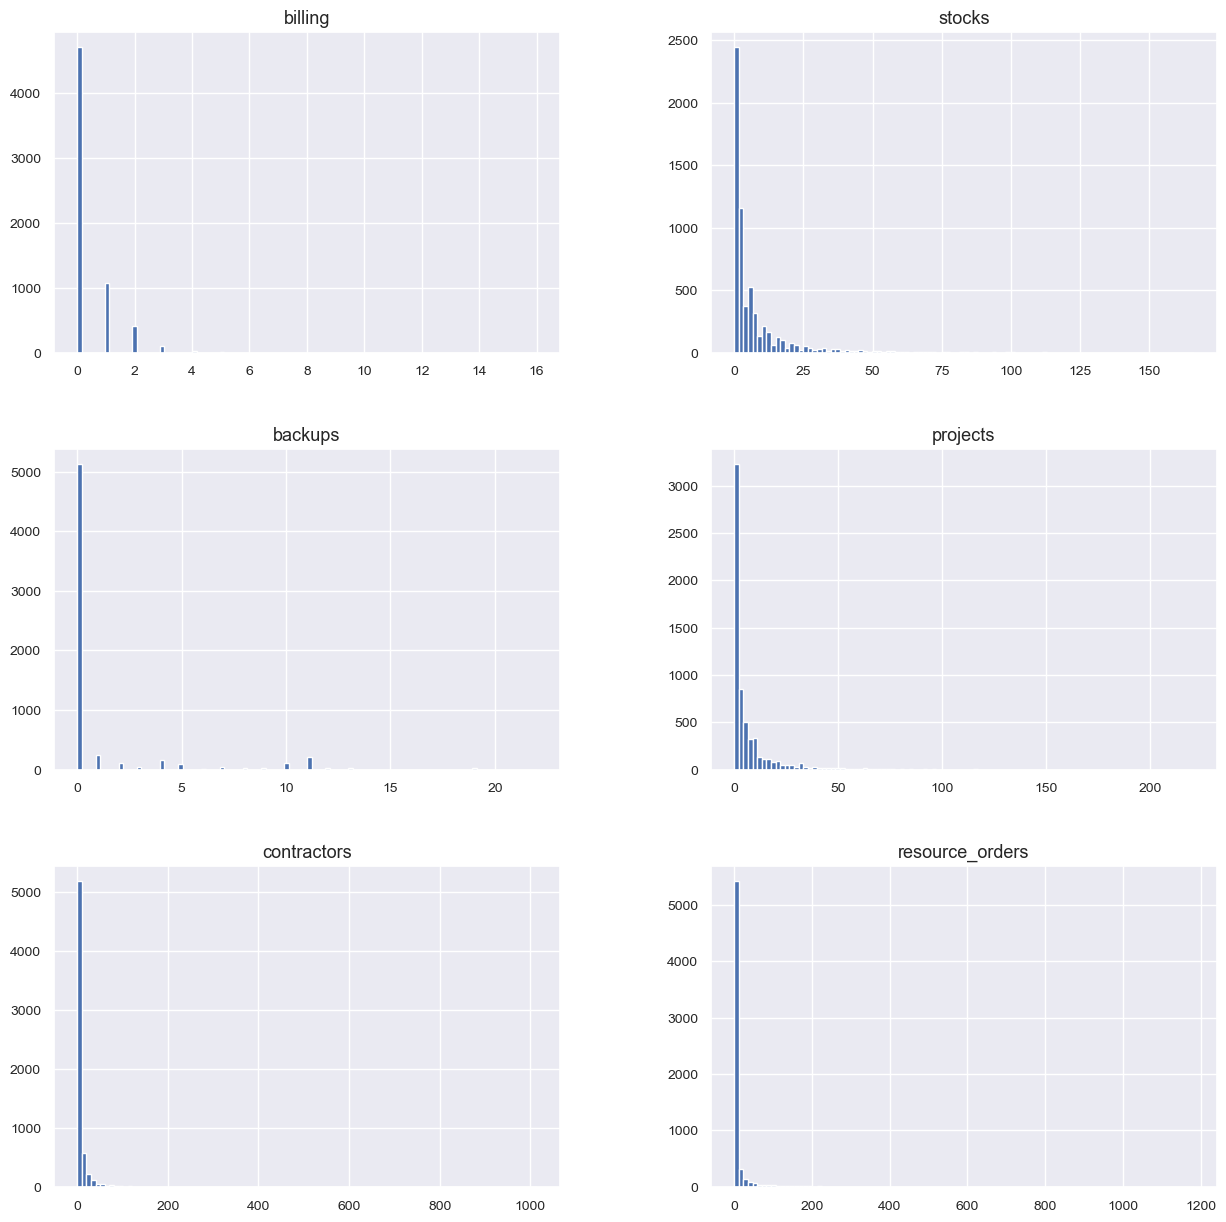

In [65]:
activities.drop(['company_id'], axis = 1).hist(figsize=(15, 15), bins = 100);

В каждом из столбцов информация неоднородна, имеется большое количество выбросов, аномально больших значений, по сравнению с средними медианным значением, что необходимо учитывать при проведении анализа. При этом аномально большие значения не уникальны, а предположение, что аномально большие значения в столбцах являются результатом деятельности крупных компаний не подтвердилось. 
Большинство таких значений внесены в данные компаниями с малой численностью сотрудников.

**Вывод:** Данные подготовлены для анализа. Удалены столбцы, не представляющие интереса для аналиа, откорректирован тип данных в столбцах.  
Необходимо рекомендовать заказчику уточнить корректность внесения информации в данные об активности клиентов.

#### Изучение и предобработка данных в датасете "people"(информация о сотрудниках компаний) 

Изучим основную информацию в столбце.

In [66]:
people.head()

,Unnamed: 0,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,2,6601,495,NaN,7133,2019-10-08,2019-10-08,True,2020-07-06
1,6,7025,1,NaN,1,2020-07-07,2020-07-07,True,2020-07-07
2,7,7165,1255,1734.0,18085,2020-07-22,2020-07-22,True,2021-10-11
3,10,7130,1470,1703.0,1,2020-07-20,2020-07-20,False,NaT
4,17,7163,1492,1731.0,1,2020-07-22,2020-08-27,True,2021-05-05


In [67]:
inform(people)

Количество строк в датафрейме: 5095

Информация о столбцах датафрейма:

1) Столбец "Unnamed: 0":
Тип данных: int64
Количество уникальных значений: 5095.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
2) Столбец "id":
Тип данных: int64
Количество уникальных значений: 5095.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
3) Столбец "company_id":
Тип данных: int64
Количество уникальных значений: 712.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
4) Столбец "user_id":
Тип данных: float64
Количество уникальных значений: 3528.
Количество пропусков в столбце: 1282 (25.16%).
Выбросы отсутствуют.
---------------------------------------------
5) Столбец "role_id":
Тип данных: int64
Количество уникальных значений: 1411.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
6) Столбец "created_at":
Тип данных: object
Количество уникальных 

Отфильтруем данные по ID компаний, присутсующих в остальных датасетах.

In [68]:
people = people.query('company_id in @companies_list')

Удалим столбцы, не представляющие интереса для исследования.

In [69]:
people.drop(['Unnamed: 0','updated_at'],axis = 1, inplace=True)

Проверим на наличие явных дубликатов.

In [70]:
people.duplicated().sum()

0

Помимо пропусков данных в столбце 'user_id', сумма пропущенных значений и уникальных значений в столбце предполагает наличие дубликатов.

Изучим строки с пропущенными значениями в столбце с ID сотрудника.

In [71]:
people.query('user_id.isna()')

,id,company_id,user_id,role_id,created_at,is_deleted,deleted_at
0,6601,495,NaN,7133,2019-10-08,True,2020-07-06
1,7025,1,NaN,1,2020-07-07,True,2020-07-07
6,6749,667,NaN,9614,2020-01-24,True,NaT
7,6740,667,NaN,9614,2020-01-16,True,NaT
18,7027,694,NaN,9994,2020-07-07,True,2020-08-06
...,...,...,...,...,...,...,...
5078,21826,9394,NaN,1,2023-12-07,False,NaT
5079,21851,8789,NaN,124383,2023-12-08,False,NaT
5081,21854,7269,NaN,102911,2023-12-08,False,NaT
5082,21853,8789,NaN,124382,2023-12-08,True,2023-12-08


Среди сотрудников с пропусками в 'user_id' имеются как удаленные, так и не удаленные пользователи.

Рассмотрим дубликаты в столбце.

In [72]:
people[(people['user_id'].duplicated(keep = False))&(people['user_id'].notna())].sort_values('user_id', ascending= False)

,id,company_id,user_id,role_id,created_at,is_deleted,deleted_at
5080,21852,8789,12901.0,124382,2023-12-08,False,NaT
5053,21775,8789,12901.0,124380,2023-12-04,True,2023-12-05
5017,21672,9278,12822.0,131244,2023-11-27,True,2023-11-27
5016,21671,9278,12822.0,1,2023-11-27,True,2023-11-27
5015,21667,9278,12822.0,1,2023-11-27,True,2023-11-27
...,...,...,...,...,...,...,...
2195,13466,541,602.0,1,2022-02-03,False,NaT
3491,17177,408,114.0,1,2023-01-10,False,NaT
3510,6530,408,114.0,1,2019-08-14,True,2023-01-10
4744,20841,8900,6.0,1,2023-10-04,True,2023-10-04


In [73]:
user_dup = people.query('not is_deleted')
user_dup[(user_dup['user_id'].duplicated(keep = False))&(user_dup['user_id'].notna())].sort_values('user_id', ascending= False).head(10)             

,id,company_id,user_id,role_id,created_at,is_deleted,deleted_at
4277,19476,8338,11210.0,118014,2023-07-11,False,NaT
4268,19447,6305,11210.0,89251,2023-07-10,False,NaT
4280,19480,8338,11209.0,118011,2023-07-11,False,NaT
4269,19451,6305,11209.0,89248,2023-07-10,False,NaT
4276,19475,8338,11199.0,118011,2023-07-11,False,NaT
4260,19431,6305,11199.0,89248,2023-07-08,False,NaT
3598,17464,3003,9525.0,42634,2023-01-31,False,NaT
3543,17244,7159,9525.0,1,2023-01-13,False,NaT
4486,19995,8595,8593.0,121634,2023-08-18,False,NaT
3054,15917,6566,8593.0,1,2022-08-18,False,NaT


Дубликаты в столбце 'user_id' не вызваны присвоением ID ранее удаленного пользователя новому пользователю.
В данных имеются дубликаты среди действующих пользователей как в рамках одной компании, так и среди разных.

**Вывод:** Данные подготовлены для анализа. Проработаны пропуски, удалены столбцы, не представляющие интереса для аналиа, Откорректирован тип данных в столбцах.  
Необходимо рекомендовать заказчику уточнить корректность формирования ID пользователей, для исключения возникновения дубликатов.

### Вывод:
 Данные загружены, изучены и подготовлены для анализа:Проработаны пропуски, удалены столбцы, не представляющие интереса для аналиа, откорректирован тип данных в столбцах.  
 
Необходимо рекомендовать заказчику:
1. Унифицировать варианты внесения информацию в столбце с сферой деятельности компаний. 
2. Уточнить корректность внесения информации в столбец с датой оплаты и его взаимосвязь с статусом оплаты.
3. Уточнить корректность внесения информации в данные об активности клиентов.
4. Уточнить корректность формирования ID пользователей, для исключения возникновения пропущенных значений и дубликатов.

## Исследовательский анализ данных:

### Определение отточных компаний

Объявим функцию определяющую отточность клиентов.
При этом будем руководствоваться следующей логикой: 
 * Клиентов, у которых максимальная дата в столбце "payed_until"  меньше текущей даты, будем считать отточными.
 * Клиентов, у которых максимальная дата в столбце "payed_until" больше текущей даты, считаем действующими, если имеется хоть одна оплата подписки с датой окончания подписки позже текущей даты.

In [74]:
current_date = date(2024,3,28) #текущая дата

In [75]:
def is_churn(id):
    ''' Функция определяет отточность клиентов'''
    is_payed_data = billing.query('company_id == @id') #формируем выборку данных по компании
    if is_payed_data['payed_until'].max() < current_date: #возвращаем True если максимальная дата в столбце с датой окончания подписки меньше текущей
        return True
    return is_payed_data.query('payed_until > @current_date').is_payed.mean() == 0 #Определяем, есть ли оплаченные подписки с датой окончания больше текущей

Применяем функцию и формируем признак отточности. Тем самым мы определили действующих пользователей.

In [76]:
billing['churn'] = billing['company_id'].map(is_churn)

Дополнительно изучим отточных клиентов.

Просмотрим неоплаченные подписки с датой окончания позже текущей даты.

In [77]:
billing.query('churn and payed_until > @current_date')

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,pay_date,churn
55,3045,567,512,2,2026-01-05,False,2020-12-21,2020-12-21,1,NaT,True
101,3047,567,512,7,2033-04-10,False,2020-12-21,2020-12-21,23,NaT,True
557,4063,567,512,2,2026-12-05,False,2021-05-11,2021-05-11,8,NaT,True
1230,3024,783,694,3,2029-02-01,False,2020-12-17,2020-12-17,9,NaT,True
2070,7652,548,495,2,2024-09-01,False,2022-03-11,2022-03-11,8,NaT,True
2613,9458,7909,6086,2,2024-04-11,False,2022-10-11,2022-10-11,24,NaT,True
2622,9500,8955,6811,9,2024-10-21,False,2022-10-17,2022-10-17,36,NaT,True
2753,9963,2608,2265,7,2024-12-20,False,2023-01-12,2023-01-12,23,NaT,True
2926,10789,5385,4278,2,2024-10-24,False,2023-04-24,2023-04-24,24,NaT,True
2982,11119,9692,7274,2,2024-12-07,False,2023-06-07,2023-06-07,24,NaT,True


Среди неоплаченных есть подписки, последнее обновление которых  произошло более 2 лет назад.  
Даже в случае отложенного платежа неоплаченные подписки с таким сроком давности врядли можно считать актуальными.  
Так как существуюет вероятность неотображения в данных оплаченных подписок(информация не прогрузилась на момент выгрузки данных), а также отложенного платежа, отфильтруем эти подписки по дате последнего обновления. Установим корректный срок - с 01.01.2024. Так как подписки, неоплаченные в течение более чем трех месяцев нельзя считать актуальными. 
Компании, которым были выставлены счета по данным подпискам, переведем из отточных в действующие.

In [78]:
old_data = date(2024,1,1)
comp_list = billing.query('churn and payed_until > @current_date and updated_at >= @old_data').company_id.unique()

In [79]:
billing.query('churn').company_id.nunique()

488

In [80]:
billing.loc[billing['company_id'].isin(comp_list), 'churn' ] =  False

In [81]:
billing.query('churn').company_id.nunique()

479

В статус действующих клиентов переведены 9 пользователей.

Также изучим компании, с момента окончания подписки прошло менее 1 месяца. Так как имеется вероятность, что данные компании не успели продлить подписку.

In [82]:
until_date = date(2024,3,1)
billing.query('churn  and is_payed and payed_until > @until_date')

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,pay_date,churn
2157,7827,6892,5376,2,2024-03-21,True,2022-03-28,2022-04-21,24,2022-04-21,True
2456,8711,8158,6256,7,2024-03-07,True,2022-06-21,2024-03-04,26,2022-06-28,True
2464,8783,8185,6279,2,2024-03-05,True,2022-06-30,2022-06-30,24,2022-06-30,True
2472,8752,7555,5817,2,2024-03-04,True,2022-06-27,2022-08-10,24,2022-06-27,True
2534,8956,6607,5176,2,2024-03-25,True,2022-07-22,2022-07-25,24,2022-07-25,True
2703,9837,9359,7052,9,2024-03-24,True,2022-12-19,2022-12-19,29,2022-12-19,True
2769,10070,9239,6972,2,2024-03-24,True,2023-01-24,2023-01-24,8,2023-01-24,True
2816,10198,425,383,7,2024-03-16,True,2023-02-09,2023-02-16,23,2023-02-16,True
2868,10470,3568,3003,7,2024-03-02,True,2023-03-17,2023-03-17,23,2023-03-17,True
3471,13013,13060,9626,7,2024-03-11,True,2023-12-26,2024-03-11,23,2024-01-15,True


Сформируем список ID  этих компаний  и проверим их активность в 2024 году.

In [83]:
comp_list_2 = billing.query('churn  and is_payed and payed_until > @until_date').company_id.unique()
comp_list_2

array([5376, 6256, 6279, 5817, 5176, 7052, 6972,  383, 3003, 9626],
      dtype=int64)

In [84]:
activities.query('company_id in @comp_list_2 and month >= @old_data')

,company_id,month,billing,stocks,backups,projects,contractors,resource_orders
1246,6256,2024-03-01,1,0,0,0,0,0
1595,9626,2024-01-01,1,11,0,9,8,16
1596,9626,2024-03-01,1,0,0,0,0,0
6043,7052,2024-02-01,0,0,0,1,0,0
6092,9626,2024-02-01,0,0,0,1,0,0
6206,6279,2024-01-01,0,0,0,0,1,4


Компании, которые проявляли активность в текущем году также переведем из отточных в действующие.

In [85]:
activ = activities.query('company_id in @comp_list_2 and month >= @old_data').company_id.unique()
billing.loc[billing['company_id'].isin(activ), 'churn' ] =  False

In [86]:
billing.query('churn').company_id.nunique()

475

**Вывод:** Признак отточности сформирован на основе наличия подписки, действующей на текущий момент. Также действующими клиентами определены компании, активные в 2024 году, подписка которых истекла в марте 2024 года, и компании, имеющие неоплаченные подписки, сформированные в 2024 году.

### Выявление признаков отточности

#### Выявление признаков отточности в датасете "billing"(информация о платежах)

Так как заказчиком не предоставлена информация о фактической стоимости тарифов, а ценообразование по каждому из тарифов может производиться на основании индивидуального подхода к каждому клиенту, исследование зависимости оттока от категории стоимости тарифов не представляется возможным.

##### Распределение оттока компаний в зависимости от стабильности оплаты

Также возможным признаком отточности может быть стабильность оплаты.
Вычислим долю оплаченных подписок по каждому пользователю.

In [87]:
billing_payed = billing.groupby('company_id').agg({'is_payed': 'sum', 'created_at': 'count', 'churn': 'first'}).reset_index()
billing_payed['payed_ratio'] = billing_payed['is_payed'] / billing_payed['created_at']

Построим визуализацию распределения оттока компаний в зависимости от доли оплаченных компанией подписок.

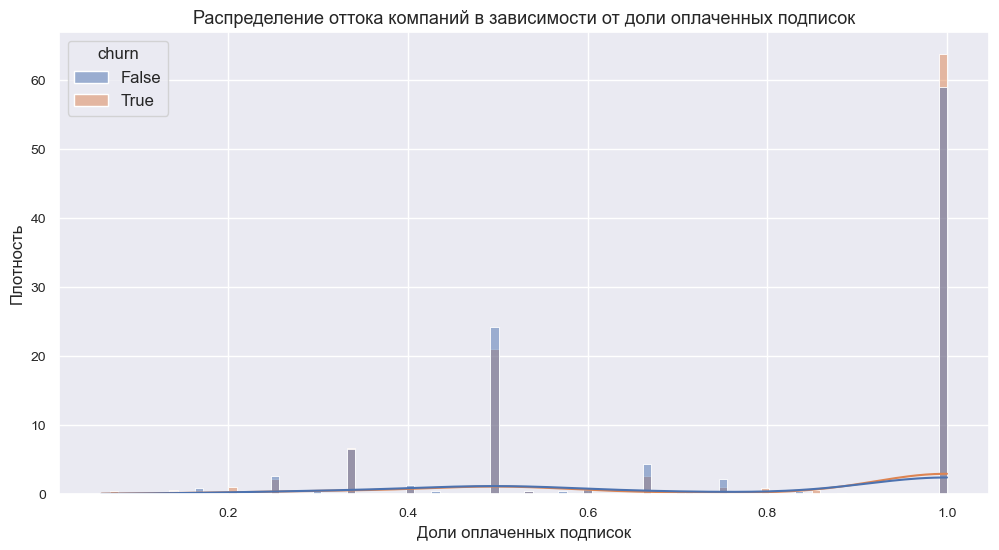

In [88]:
group_visual(billing_payed,'payed_ratio',bins = 100)

График малоинформативен, поэтому визуализируем распределение с ограничением диапазонов по осям.

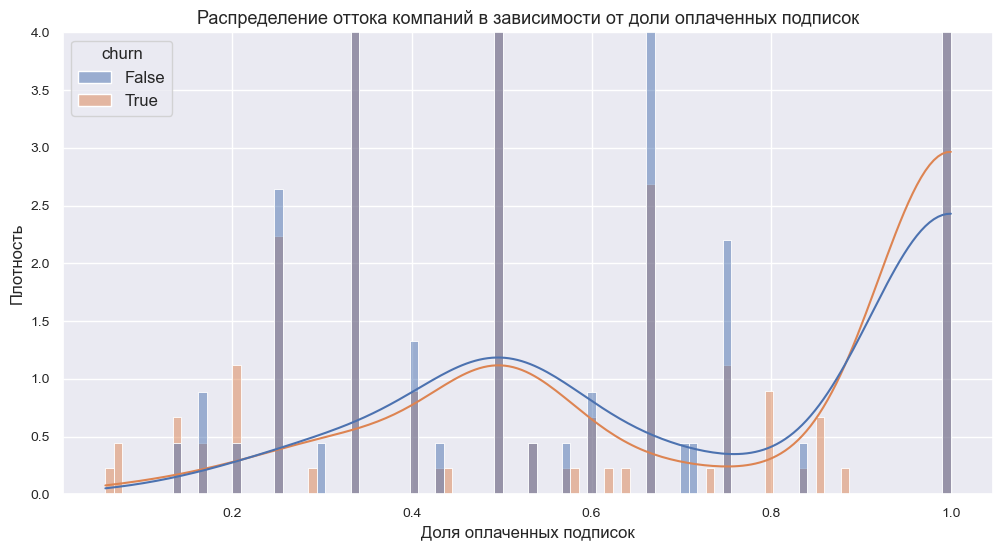

In [89]:
# не пользуюсь функцией, так как необходимо ограничить диапазон по оси y.
sns.histplot(data=billing_payed, x='payed_ratio', hue='churn', bins=100, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение оттока компаний в зависимости от доли оплаченных подписок')
plt.xlabel(f'Доля оплаченных подписок')
plt.ylabel('Плотность')
plt.ylim(0,4)
plt.show()

Визуально доля оплаченных подписок между ушедшими и действующими клиентами существенно не отличается.

In [90]:
for i in range(1,10):
    print(f'Доля оплаченных подписок > {i/10}')
    print(churn_group(billing_payed,f'payed_ratio > {i/10}'))
    print()

Доля оплаченных подписок > 0.1
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.661992              713                                      716

Доля оплаченных подписок > 0.2
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.660944              699                                      716

Доля оплаченных подписок > 0.3
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.662261              681                                      716

Доля оплаченных подписок > 0.4
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.662957              629                                      716

Доля оплаченных подписок > 0.5
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.672956              477                                      716

Доля оплаченных подписок > 0.6
     Отток  Размер сегмента  Общее количество пользователей в данных
0  0.67382              466             

In [91]:
for i in range(1,10):
    print(f'Доля оплаченных подписок < {i/10}')
    print(churn_group(billing_payed,f'payed_ratio < {i/10}'))
    print()

Доля оплаченных подписок < 0.1
   Отток  Размер сегмента  Общее количество пользователей в данных
0    1.0                3                                      716

Доля оплаченных подписок < 0.2
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.727273               11                                      716

Доля оплаченных подписок < 0.3
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.705882               34                                      716

Доля оплаченных подписок < 0.4
   Отток  Размер сегмента  Общее количество пользователей в данных
0  0.675               80                                      716

Доля оплаченных подписок < 0.5
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.666667               90                                      716

Доля оплаченных подписок < 0.6
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.644898              245                       

Крупные высокоотточные сегменты в ходе анализа не выявлены. Категоризация данных в данном случае нецелесообразна.

Проверим разницу в доле оплаченных подписок между ушедшими и действующими клиентами статистически.  
Сформулируем гипотезы:

H_0: Средняя доля счетов, оплаченных компанией из числа ушедших = Средняя доля счетов, оплаченных компанией из числа действующих.

H_1: Средняя доля счетов, оплаченных компанией из числа ушедших ≠ Средняя доля счетов, оплаченных компанией из числа действующих.

Так как распределение признака отличное от нормального, используем критерий Манна-Уитни.

In [92]:
results = st.mannwhitneyu(billing_payed.query('churn')['payed_ratio']
                          , billing_payed.query('not churn')['payed_ratio'])
print('p-value:', results.pvalue)
alpha = .05 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.37201924766759575
Не получилось отвергнуть нулевую гипотезу


Отточные и неотточные компании оплачивают равное количество счетов.

**Вывод:** Стабильность оплаты не является признаком отточных компаний.

#### Выявление признаков отточности в датасете "companies"(информация о компаниях)

Присоеденим к датасет companies столбец с категорией отточности.

In [93]:
companies_churn = billing.groupby('company_id').churn.first().reset_index()

In [94]:
companies = companies.merge(companies_churn, on = 'company_id')
companies['created_at'] = pd.to_datetime(companies['created_at'])

##### Распределение оттока компаний в зависимости от количества месяцев активности

Проанализируем отточность клиентов в зависимости от даты регистрации компании в сервисе.

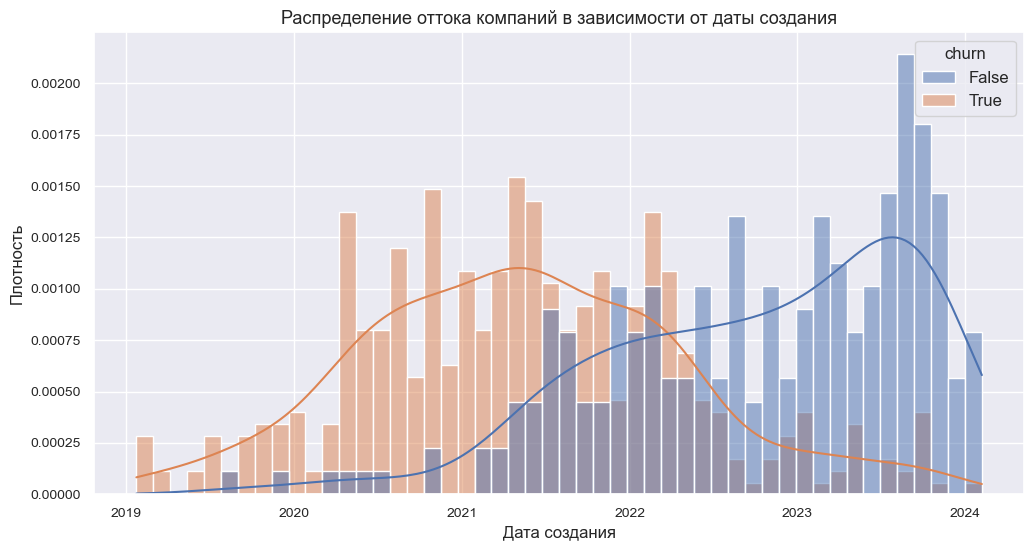

In [95]:
group_visual(companies, 'created_at')

In [96]:
for i in [date(2022,2,15), date(2022,3,1), date(2022,3,15), date(2022,4,1)]:
    data = i # 
    print(f'Дата регистрации  компании ранее {i}')
    print(churn_group(companies,f'created_at < @data'))
    print()

Дата регистрации  компании ранее 2022-02-15
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.854545              440                                      716

Дата регистрации  компании ранее 2022-03-01
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.851111              450                                      716

Дата регистрации  компании ранее 2022-03-15
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.847162              458                                      716

Дата регистрации  компании ранее 2022-04-01
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.845824              467                                      716



**Вывод:** Границей интервала установим 1 марта 2022 года. Отточность на данном интервале составляет интервале 85%.

Разделим компании в зависимости от даты регистрации на 2 категории.

In [97]:
def create_cat(cell):
    if cell.date() < date(2022,3,1):
        return 'I'
    return 'II'

In [98]:
companies['created_category'] = companies['created_at'].map(create_cat)

##### Распределение оттока компаний в зависимости от количества сотрудников

Проанализируем отточность клиентов в зависимости от количества сотрудников.

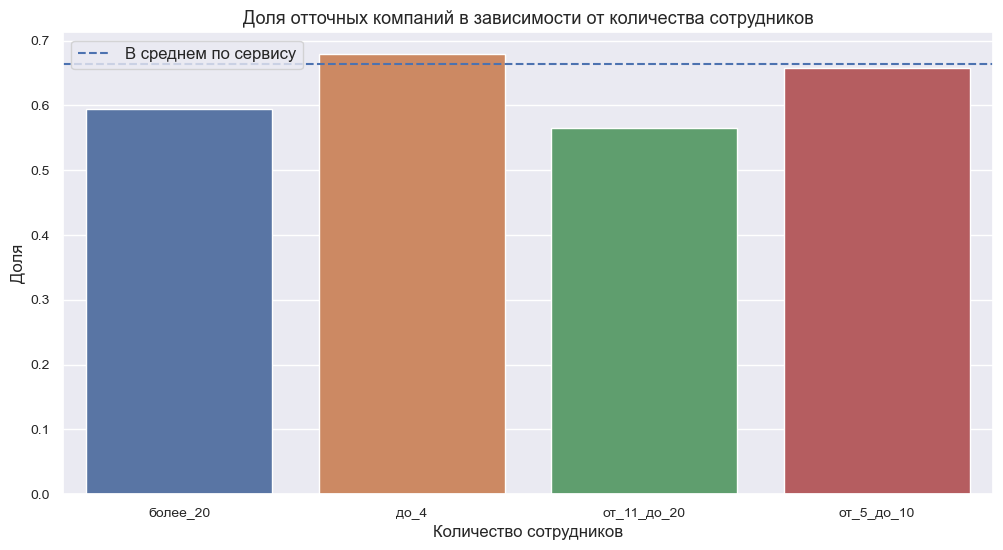

In [99]:
group_visual(companies, 'count_employees')

In [100]:
for i in companies.count_employees.unique():
    print(f'Количество сотрудников  {i}')
    print(churn_group(companies,f'count_employees=="{i}"'))
    print()

Количество сотрудников  до_4
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.678862              492                                      716

Количество сотрудников  от_5_до_10
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.657534              146                                      716

Количество сотрудников  более_20
     Отток  Размер сегмента  Общее количество пользователей в данных
0  0.59375               32                                      716

Количество сотрудников  от_11_до_20
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.565217               46                                      716



**Вывод:**  Наибольший отток клиентов   фиксируется в  компаниях с численностью сотрудников до 4 человек. 

##### Распределение оттока компаний в зависимости от группы тарифа

Проанализируем отточность клиентов в зависимости от группы тарифа.

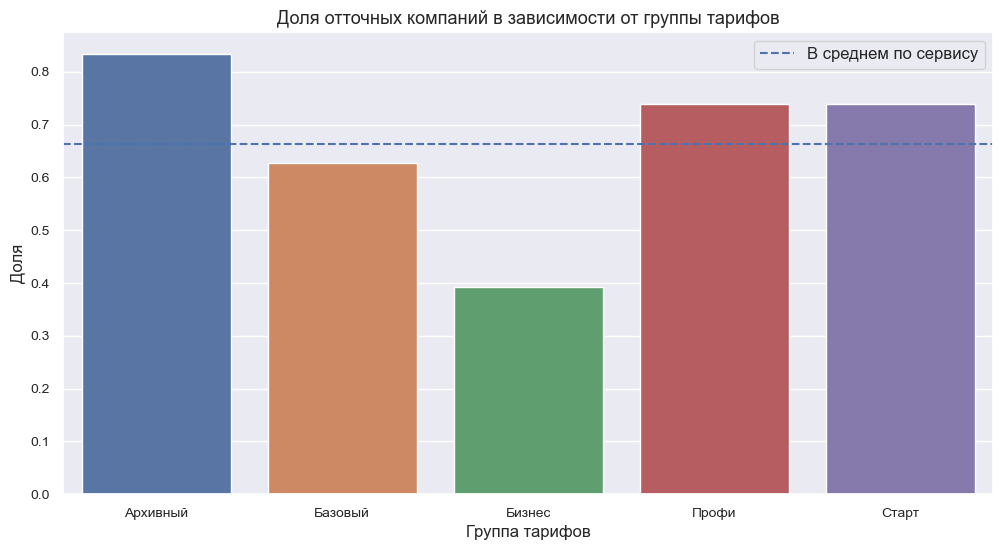

In [101]:
group_visual(companies, 'tariffs_groups')

In [102]:
for i in companies.tariffs_groups.unique():
    print(f' Группа тарифов "{i}"')
    print(churn_group(companies,f'tariffs_groups=="{i}"'))
    print()

 Группа тарифов "Старт"
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.738562              306                                      716

 Группа тарифов "Базовый"
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.627273              330                                      716

 Группа тарифов "Профи"
     Отток  Размер сегмента  Общее количество пользователей в данных
0  0.73913               23                                      716

 Группа тарифов "Бизнес"
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.392157               51                                      716

 Группа тарифов "Архивный"
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.833333                6                                      716



**Вывод:** Наиболее крупными сегментами в зависимости от группы тарифа являются пользователи группы тарифов "Смарт" и "Базовый".
Доля оттока у пользователей группы тарифов "Смарт" составляет практически 74%, "Базовый" - практически 63%.

##### Распределение оттока компаний в зависимости от длительности пользования сервисом

Более корретным вариантом рассчета длительности пользования сервисом исходя из имеющихся данных является вычисление количества месяцев от даты регистрации, до даты последней активности. Данный подход позволит исключить случаи, когда при действующей подписке клиент перестает пользоваться сервисом и учесть случаи, когда при истекшей подписке клиет продолжает пользоваться сервисом.

Данный подход не учитывает компании, которые на время полностью прекратили использование сервиса, так как учитывает в общей длительности пользования данный период. 

In [103]:
companies = (companies.merge(activities.groupby('company_id')
                             .month.max()
                             .reset_index(), on = 'company_id'))

In [104]:
companies['total_month'] = (companies.apply(lambda x: len(pd.date_range(start=x['created_at']
                                                                        ,end=x['month']
                                                                        ,freq='M')), axis=1 ) + 1)

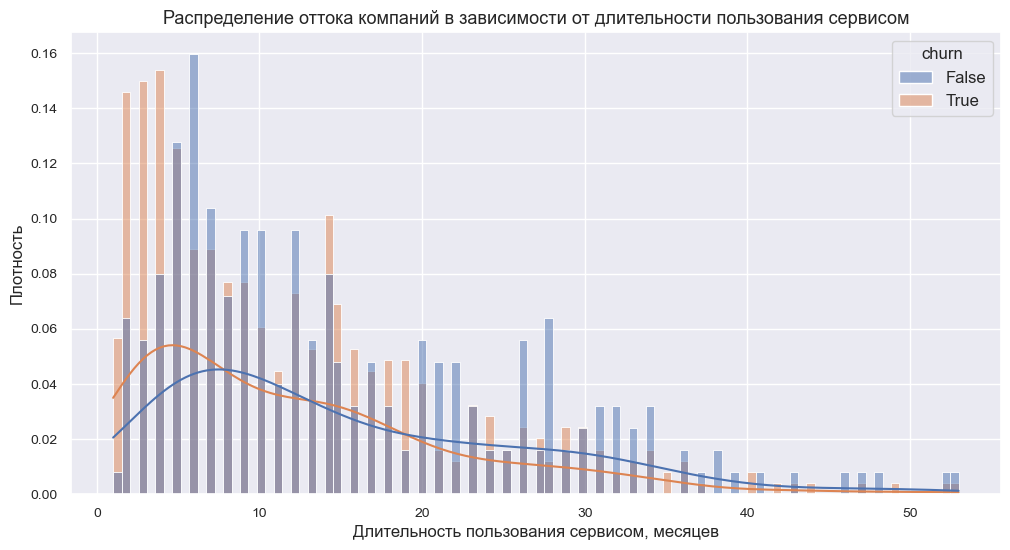

In [105]:
group_visual(companies, 'total_month', bins = 100)

In [106]:
for i in range(3,9):
    print(f'Длительность пользования сервисом < {i} месяцев')
    print(churn_group(companies,f'total_month <{i}'))

Длительность пользования сервисом < 3 месяцев
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.847458               59                                      716
Длительность пользования сервисом < 4 месяцев
     Отток  Размер сегмента  Общее количество пользователей в данных
0  0.84466              103                                      716
Длительность пользования сервисом < 5 месяцев
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.827815              151                                      716
Длительность пользования сервисом < 6 месяцев
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.787879              198                                      716
Длительность пользования сервисом < 7 месяцев
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.741667              240                                      716
Длительность пользования сервисом < 8 месяцев
      Отток  Размер сегмен

**Вывод:** Границей интервала отточности установим 6 месяцев. Отточность на данном интервале составляет интервале 78,7%.

Разделим клиентов в зависимости от продолжительности пользования сервисом на 2 категории.

In [107]:
def categorize_month(total_month):
    if total_month < 6:
        return 'I'
    return 'II'

In [108]:
companies['total_month_category'] = companies['total_month'].map(categorize_month)

**Вывод:** Отслеживается зависимость оттока клинтов сервиса от даты регистрации компании в сервисе и от количества месяцев пользования сервисом.
Более отточными являются клиенты, пользующиеся услугами сервиса менее 6 месяцев, а также клиенты, зарегистрированные в сервисе до марта 2022 года.
Кроме того, наблюдается повышенный отток клиентов, пользующихся тарифами групп "Cтарт" и "Базовый". У клиентов использующих тариф "Профи" также повышенный отток, но таких компаний менее 25.

#### Выявление признаков отточности в датасете "people"(информация о сотрудниках компаний)

Присоеденим к датасет companies столбец с категорией отточности.

In [109]:
people =people.merge(companies[['company_id','churn']], on = 'company_id')

В данных о сотрудниках компании единственный столбец, представляющий интерес для исследования - 'role_id'

Определим количество уникальных значений в столбце.

In [110]:
people.role_id.nunique()

1411

Сгруппируем данные по 'role_id'определим количество компаний в которых зарегистрированы пользователи с данной ролью и долю пользователей с данной ролью, работающих в отточных компаниях

In [111]:
role = people.groupby('role_id').agg({'company_id': 'nunique', 'churn': 'mean'}).reset_index()
role.columns = ['role_id', 'company_count', 'churn_ratio']
role.sort_values('company_count', ascending = False)

,role_id,company_count,churn_ratio
0,1,706,0.620301
1058,98670,1,0.000000
946,89767,1,0.000000
945,89764,1,0.000000
944,89762,1,0.000000
...,...,...,...
468,49977,1,1.000000
467,49975,1,1.000000
466,49974,1,1.000000
465,49973,1,1.000000


**Вывод:** Кроме 'role_id'= 1, которая по всей видимости является ролью с базовым функционалом и присутствующей практически во всех компаниях. Пересечений между компаниями не выявлено. Роли формируются только под потребности каждой компании. Данный параметр нельзя рассматривать как признак отточности.

#### Выявление признаков отточности в датасете "activities"(активность компаний)

Присоеденим к датасету столбцы с категорией отточности, а также временем пользования сервисом из таблицы "companies".

In [112]:
activities = activities.merge(companies[['company_id','churn', 'total_month']], on = 'company_id')

Сформируем сводную таблицу, в которой для каждой компании посчитаем общее количество месяцев активности и долю месяцев активности от общего количества месяцев пользования сервисом.

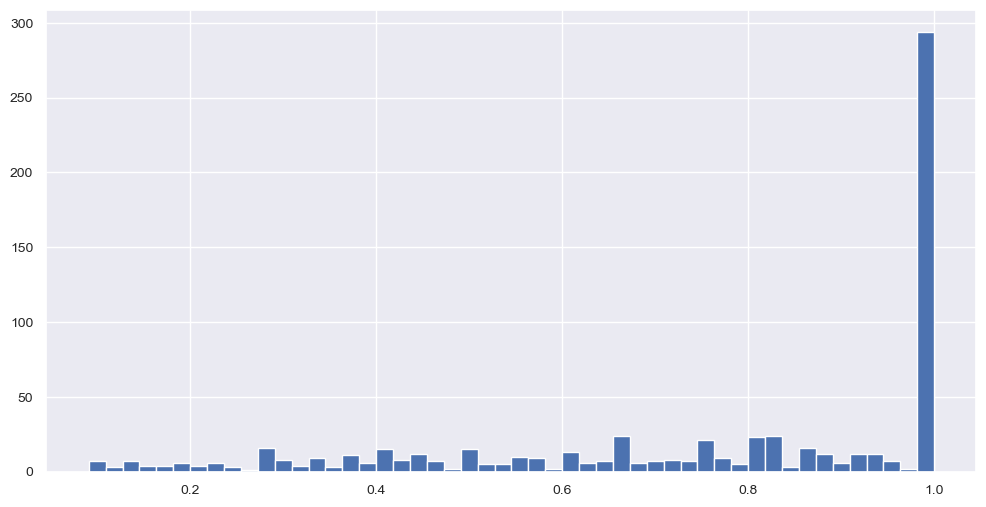

In [113]:
act_month = activities.groupby('company_id').agg({'month': 'count', 'total_month' :'first'}).reset_index()
act_month['month_act_ratio'] = act_month['month'] / act_month['total_month']
act_month.month_act_ratio.hist(bins = 50);

Частота внесения информации у пользователей системы сильно различается. Многие пользователи вносили информацию не каждый месяц, кроме того, срок пользования системой также различается. Поэтому суммирование показателей по каждому пользователю нам не подходит. Так как по техническому заданию показатели звучат как "Месячное количество", будем считать, что это значения за месяц внесения информации.  
Сформируем сводную таблицу, где момимо частоты внесения информации, рассчитанной ранее, рассчитаем по каждому пользователю средние значения по каждому показателю активности.

In [114]:
act_stat = activities.groupby('company_id').agg({'billing': 'mean',
                                                 'stocks': 'mean',
                                                 'backups':	'mean',                                             
                                                 'projects': 'mean',                                             
                                                 'contractors': 'mean',                                             
                                                 'resource_orders': 'mean',                                             
                                                 'churn': 'first',
                                                 'month': 'count',
                                                 'total_month' :'first'}).reset_index()
act_stat.rename(columns = {'month': 'month_count'}, inplace=True)

Рассчитаем  среднемесячную активность компаний как отношение количества месяцев, в течении которых компании проявляли активность к общему количеству месяцев, в течение которых компании были клиентами сервиса.

In [115]:
act_stat['month_act_ratio'] = act_stat['month_count'] / act_stat['total_month']
act_stat

,company_id,billing,stocks,backups,projects,contractors,resource_orders,churn,month_count,total_month,month_act_ratio
0,1,0.333333,2.809524,0.809524,2.714286,1.047619,0.000000,True,21,23,0.913043
1,21,0.875000,3.500000,0.000000,3.458333,5.291667,0.625000,True,24,53,0.452830
2,30,0.458333,2.583333,0.125000,2.541667,5.916667,0.000000,True,24,35,0.685714
3,108,0.666667,1.666667,0.166667,1.666667,3.500000,0.000000,True,6,47,0.127660
4,116,0.263158,2.736842,0.000000,2.631579,3.210526,3.631579,True,19,34,0.558824
...,...,...,...,...,...,...,...,...,...,...,...
711,9777,1.500000,1.000000,0.000000,1.000000,1.500000,4.000000,False,2,2,1.000000
712,9802,1.000000,11.500000,0.000000,11.500000,3.500000,4.500000,False,2,2,1.000000
713,9815,0.666667,4.000000,0.000000,3.666667,1.666667,3.000000,False,3,3,1.000000
714,9817,0.666667,4.333333,0.000000,4.333333,1.666667,1.666667,False,3,3,1.000000


Рассмотрим усредненые показатели по отточным и неотточным клиентам. Так как в столбцах было большое количество выбросов, в качестве меры центральной тенденции используем медиану.

In [116]:
act_stat.groupby('churn').agg({'billing':'median',
                              'stocks':'median',
                              'backups':'median',
                              'projects':'median',
                              'contractors':'median',
                              'resource_orders':'median',
                              'month_count':'mean',
                              'total_month' :'mean',
                              'month_act_ratio': 'mean'})

,billing,stocks,backups,projects,contractors,resource_orders,month_count,total_month,month_act_ratio
churn,,,,,,,,,
False,0.333333,3.750000,0.0,3.600000,4.600000,2.857143,11.045643,15.360996,0.789786
True,0.500000,2.666667,0.0,2.555556,2.666667,1.000000,7.692632,12.193684,0.744923


В целом практически все показатели у действующих клиентов выше, чем у ушедших. За исключением количества счетов, выставленных в приложении, компанией за месяц 

Рассмотрим распределение оттока компаний в зависимости от всех этих признаков.

##### Распределение оттока компаний в зависимости от количества месяцев активности

Проанализируем распределение оттока компаний в зависимости от количества месяцев активности.

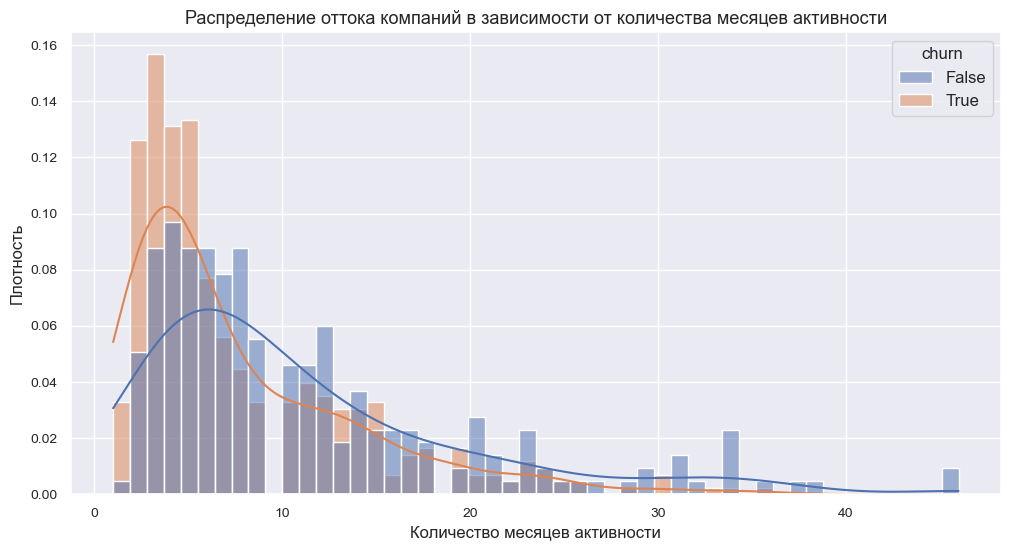

In [117]:
group_visual(act_stat, 'month_count')

In [118]:
for i in range(5,9):
    print(f'Количество месяцев, в течение которых пользователи проявляли активность < {i}')
    print(churn_group(act_stat,f'month_count<{i}'))

Количество месяцев, в течение которых пользователи проявляли активность < 5
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.786008              243                                      716
Количество месяцев, в течение которых пользователи проявляли активность < 6
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.777429              319                                      716
Количество месяцев, в течение которых пользователи проявляли активность < 7
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.757412              371                                      716
Количество месяцев, в течение которых пользователи проявляли активность < 8
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.740291              412                                      716


Границей интервала установим 7 месяцев активности. Отточность на данном интервале составляет интервале 75,7%. 

Разделим пользователей на 2 категории.

In [119]:
def categorize_act_month(month_count):
    if month_count < 7:
        return 'I'
    return 'II'

In [120]:
act_stat['month_activity_category'] = act_stat['month_count'].map(categorize_act_month)

##### Распределение оттока компаний в зависимости от частоты активности

Проанализируем распределение оттока компаний в зависимости от частоты активности.

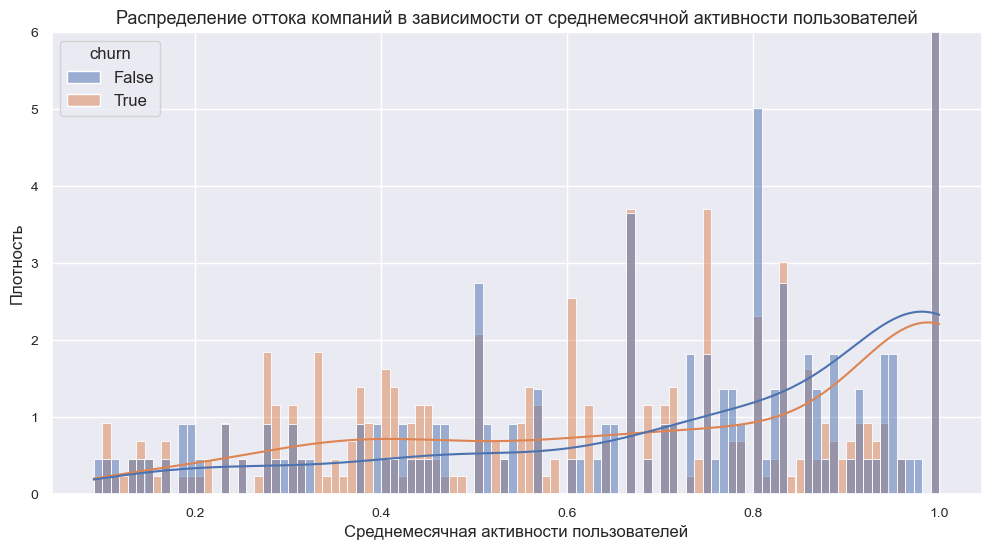

In [121]:
# не пользуюсь функцией, так как необходимо ограничить диапазон по оси y.
sns.histplot(data=act_stat, x='month_act_ratio', hue='churn', bins=100, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение оттока компаний в зависимости от среднемесячной активности пользователей')
plt.xlabel(f'Среднемесячная активности пользователей')
plt.ylabel('Плотность')
plt.ylim(0,6)
plt.show()

In [122]:
for i in range(5,9):
    print(f'Количество месяцев, в течение которых пользователи проявляли активность < {i/10}')
    print(churn_group(act_stat,f'month_act_ratio<{i/10}'))

Количество месяцев, в течение которых пользователи проявляли активность < 0.5
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.739726              146                                      716
Количество месяцев, в течение которых пользователи проявляли активность < 0.6
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.729167              192                                      716
Количество месяцев, в течение которых пользователи проявляли активность < 0.7
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.725806              248                                      716
Количество месяцев, в течение которых пользователи проявляли активность < 0.8
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.708197              305                                      716


**Вывод:** Границей интервала установим среднемесячная активность менее 0,7, доля оттока на данном интервале составляет 72,5%. 

Категоризируем данные значения.

In [123]:
def categorize_act_ratio(month_act_ratio):
    if month_act_ratio < 0.7:
        return 'I'
    return 'II'

In [124]:
act_stat['activity_frequency_category'] = act_stat['month_act_ratio'].map(categorize_act_ratio)

##### Распределение оттока компаний в зависимости от среднего количества счетов, выставленных компанией в месяц

Проанализируем отточность клиентов в зависимости от среднего количества счетов, выставленных компанией в месяц

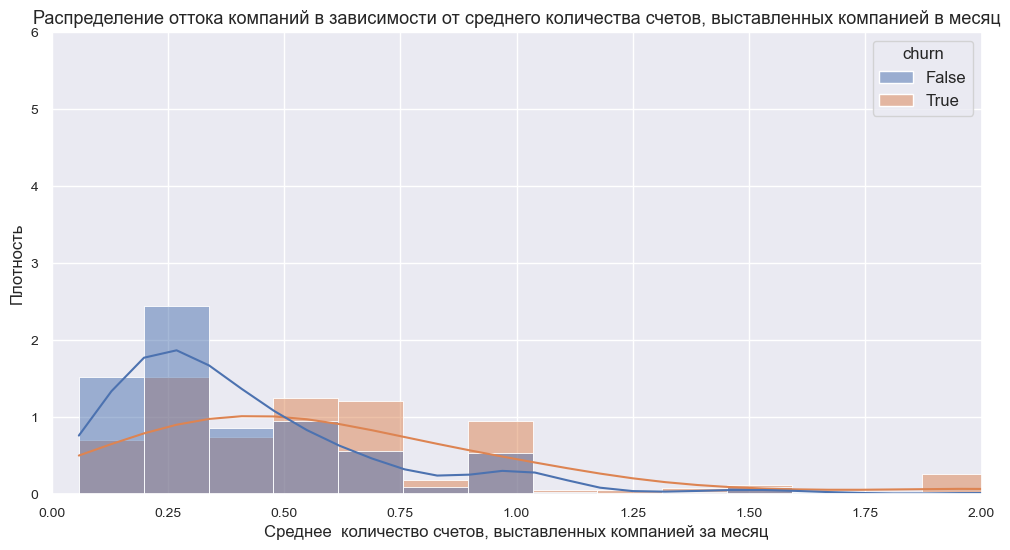

In [125]:
# не пользуюсь функцией, так как необходимо ограничить диапазон по оси y.
sns.histplot(data=act_stat, x='billing', hue='churn', bins=100, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение оттока компаний в зависимости от среднего количества счетов, выставленных компанией в месяц')
plt.xlabel(f'Среднее  количество счетов, выставленных компанией за месяц')
plt.ylabel('Плотность')
plt.ylim(0,6)
plt.xlim(0,2)
plt.show()

In [126]:
for i in range(1,7):
    print(f'Среднее  количество счетов, выставленных компанией за месяц > {i/10}')
    print(churn_group(act_stat,f'billing>{i/10}'))
    print()

Среднее  количество счетов, выставленных компанией за месяц > 0.1
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.667139              706                                      716

Среднее  количество счетов, выставленных компанией за месяц > 0.2
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.692821              599                                      716

Среднее  количество счетов, выставленных компанией за месяц > 0.3
     Отток  Размер сегмента  Общее количество пользователей в данных
0  0.73444              482                                      716

Среднее  количество счетов, выставленных компанией за месяц > 0.4
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.765789              380                                      716

Среднее  количество счетов, выставленных компанией за месяц > 0.5
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.805054              277          

Границей интервала установим среднемесячное количество счетов в размере 0,5. Отточность на данном интервале составляет  более 80%.
Категоризируем данные значения.

In [127]:
def categorize_billing(billing):
    if billing > 0.5:
        return 'I'
    return 'II'

In [128]:
act_stat['billing_category'] = act_stat['billing'].map(categorize_billing)

##### Распределение оттока компаний в зависимости от среднего количества складов, используемое компанией за месяц

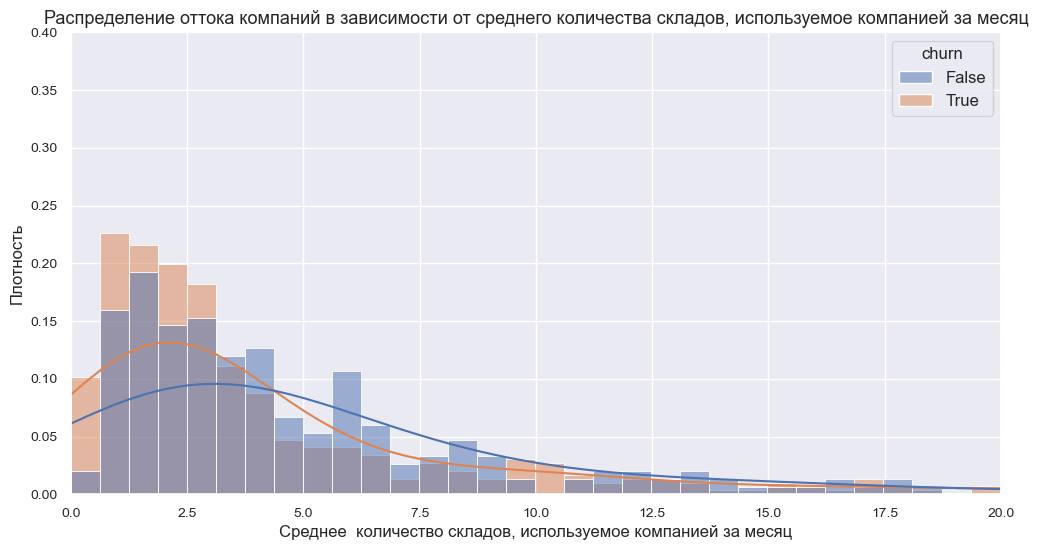

In [129]:
# не пользуюсь функцией, так как необходимо ограничить диапазон по оси y.
sns.histplot(data=act_stat, x='stocks', hue='churn', bins=100, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение оттока компаний в зависимости от среднего количества складов, используемое компанией за месяц')
plt.xlabel(f'Среднее  количество складов, используемое компанией за месяц')
plt.ylabel('Плотность')
plt.ylim(0,0.4)
plt.xlim(0,20)
plt.show()

In [130]:
for i in range(1,7):
    print(f'Среднее  количество складов, используемое компанией за месяц < {i}')
    print(churn_group(act_stat,f'stocks<{i}'))

Среднее  количество складов, используемое компанией за месяц < 1
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.793651               63                                      716
Среднее  количество складов, используемое компанией за месяц < 2
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.736364              220                                      716
Среднее  количество складов, используемое компанией за месяц < 3
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.729345              351                                      716
Среднее  количество складов, используемое компанией за месяц < 4
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.714612              438                                      716
Среднее  количество складов, используемое компанией за месяц < 5
     Отток  Размер сегмента  Общее количество пользователей в данных
0  0.70101              495                   

Границей интервала установим 4 склада в месяц. Отточность на данном интервале составляет интервале 71%.

Категоризируем данные значения.

In [131]:
def categorize_stocks(stocks):
    if stocks < 4:
        return 'I'
    return 'II'

In [132]:
act_stat['stocks_category'] = act_stat['stocks'].map(categorize_stocks)

##### Распределение оттока компаний в зависимости от среднего количества бэкапов (сохранений информации на сервисе) компании в месяц

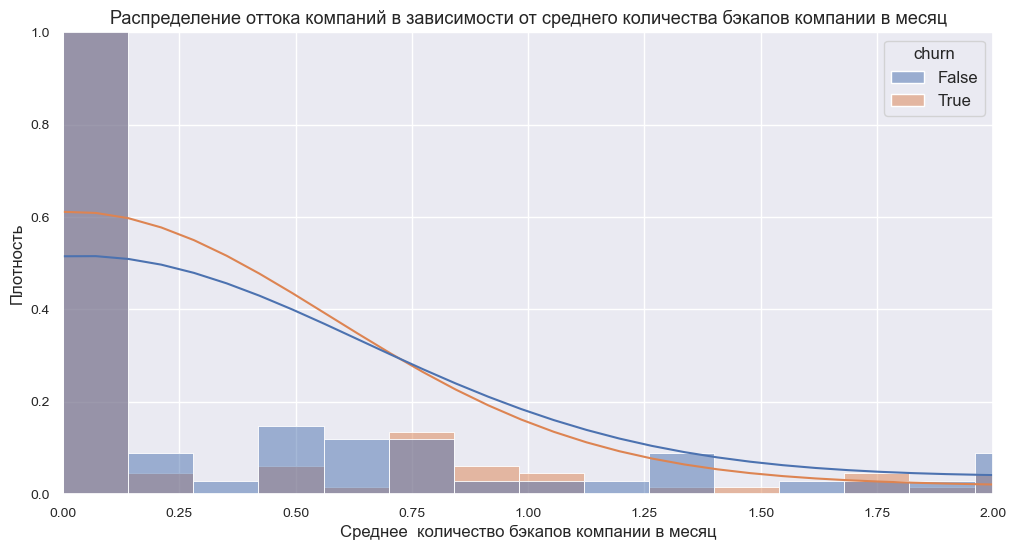

In [133]:
# не пользуюсь функцией, так как необходимо ограничить диапазон по оси y.
sns.histplot(data=act_stat, x='backups', hue='churn', bins=100, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение оттока компаний в зависимости от среднего количества бэкапов компании в месяц')
plt.xlabel(f'Среднее  количество бэкапов компании в месяц')
plt.ylabel('Плотность')
plt.ylim(0,1)
plt.xlim(0,2)
plt.show()

In [134]:
for i in range(4,10):
    print(f'Среднее  количество бэкапов компании в месяц < {i/10}')
    print(churn_group(act_stat,f'backups<{i/10}'))

Среднее  количество бэкапов компании в месяц < 0.4
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.689119              579                                      716
Среднее  количество бэкапов компании в месяц < 0.5
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.687285              582                                      716
Среднее  количество бэкапов компании в месяц < 0.6
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.685908              589                                      716
Среднее  количество бэкапов компании в месяц < 0.7
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.681282              593                                      716
Среднее  количество бэкапов компании в месяц < 0.8
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.679402              602                                      716
Среднее  количество бэкапов компании в месяц 

Границей интервала установим 0,7 бэкапов в среднем за месяц. Отточность на данном интервале составляет интервале 68%.

Категоризируем данные значения.

In [135]:
def categorize_backups(backups):
    if backups < 0.7:
        return 'I'
    return 'II'

In [136]:
act_stat['backups_category'] = act_stat['backups'].map(categorize_backups)

##### Распределение оттока компаний в зависимости от среднего количество проектов компании в месяц

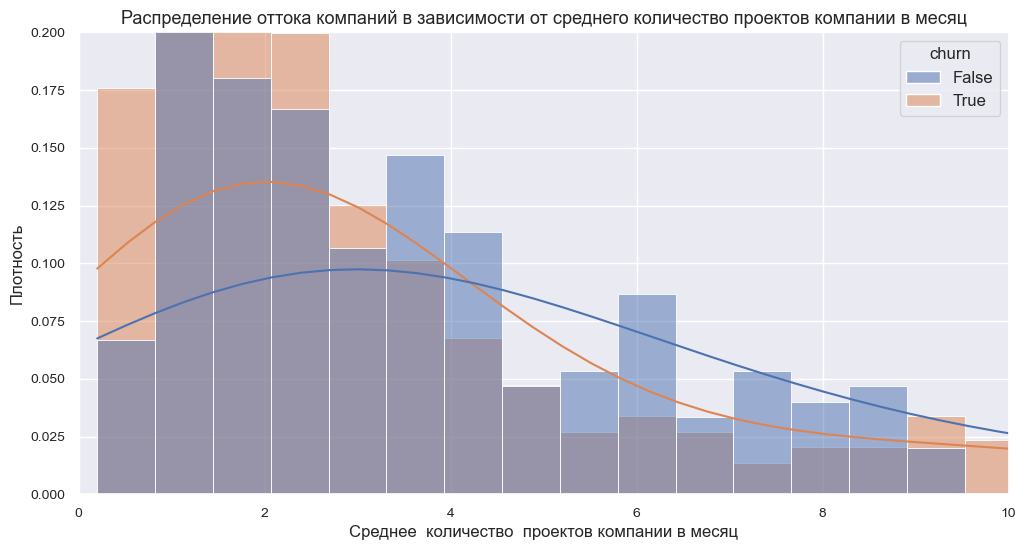

In [137]:
# не пользуюсь функцией, так как необходимо ограничить диапазон по оси y.
sns.histplot(data=act_stat, x='projects', hue='churn', bins=100, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение оттока компаний в зависимости от среднего количество проектов компании в месяц')
plt.xlabel(f'Среднее  количество  проектов компании в месяц')
plt.ylabel('Плотность')
plt.ylim(0,0.2)
plt.xlim(0,10)
plt.show()

In [138]:
for i in range(2,6):
    print(f'Среднее  количество бэкапов компании в месяц < {i}')
    print(churn_group(act_stat,f'projects<{i}'))

Среднее  количество бэкапов компании в месяц < 2
   Отток  Размер сегмента  Общее количество пользователей в данных
0   0.75              236                                      716
Среднее  количество бэкапов компании в месяц < 3
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.731507              365                                      716
Среднее  количество бэкапов компании в месяц < 4
     Отток  Размер сегмента  Общее количество пользователей в данных
0  0.71116              457                                      716
Среднее  количество бэкапов компании в месяц < 5
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.697628              506                                      716


Границей интервала установим 3 проекта в месяц. Отточность на данном интервале составляет интервале 73%.

Категоризируем данные значения.

In [139]:
def categorize_projects(projects):
    if projects < 3:
        return 'I'
    return 'II'

In [140]:
act_stat['projects_category'] = act_stat['projects'].map(categorize_projects)

##### Распределение оттока компаний в зависимости от среднего количества  контрагентов компании в месяц

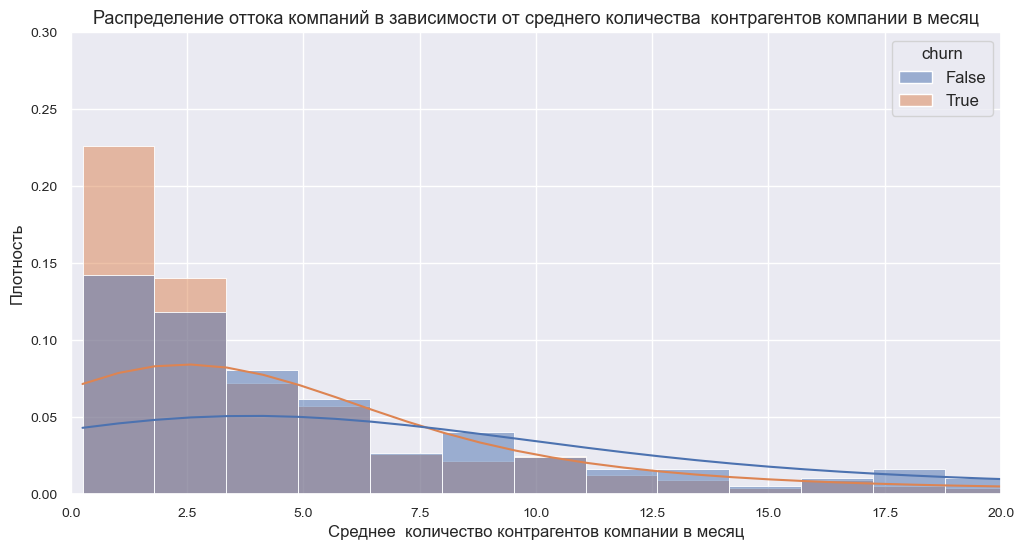

In [141]:
# не пользуюсь функцией, так как необходимо ограничить диапазон по оси y.
sns.histplot(data=act_stat, x='contractors', hue='churn', bins=100, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение оттока компаний в зависимости от среднего количества  контрагентов компании в месяц')
plt.xlabel(f'Среднее  количество контрагентов компании в месяц')
plt.ylabel('Плотность')
plt.ylim(0,0.3)
plt.xlim(0,20)
plt.show()

In [142]:
for i in range(5,10):
    print(f'Среднее  количество бэкапов компании в месяц < {i}')
    print(churn_group(act_stat,f'contractors<{i}'))

Среднее  количество бэкапов компании в месяц < 5
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.716186              451                                      716
Среднее  количество бэкапов компании в месяц < 6
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.705051              495                                      716
Среднее  количество бэкапов компании в месяц < 7
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.704981              522                                      716
Среднее  количество бэкапов компании в месяц < 8
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.705341              543                                      716
Среднее  количество бэкапов компании в месяц < 9
   Отток  Размер сегмента  Общее количество пользователей в данных
0    0.7              560                                      716


Границей интервала установим 18 контрагентов компании в месяц. Отточность на данном интервале составляет интервале 70%.
Категоризирум данные значения.

In [143]:
def categorize_contractors(contractors):
    if contractors < 8:
        return 'I'
    return 'II'

In [144]:
act_stat['contractors_category'] = act_stat['contractors'].map(categorize_contractors)

##### Распределение оттока компаний в зависимости от среднего количества  заказов материалов компании в месяц

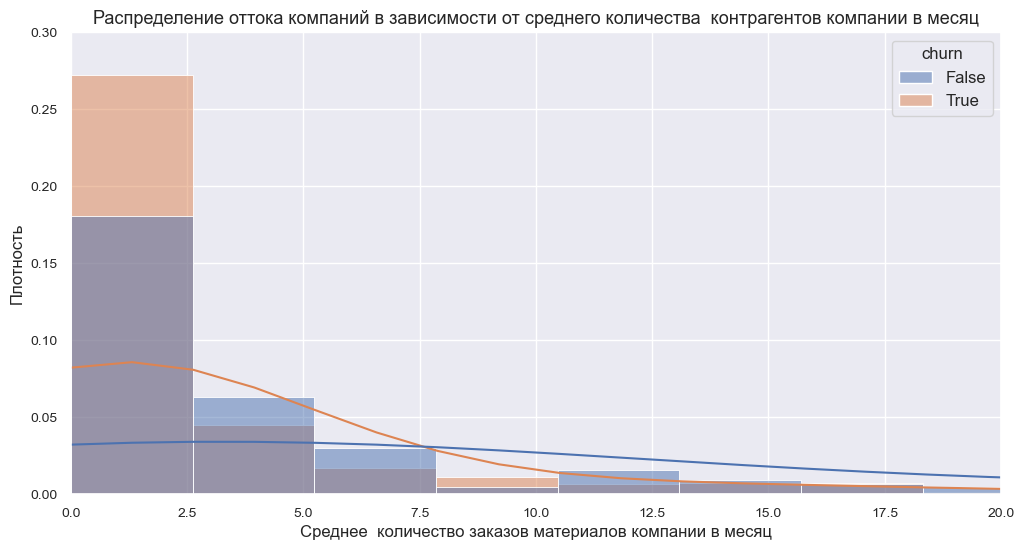

In [145]:
# не пользуюсь функцией, так как необходимо ограничить диапазон по оси y.
sns.histplot(data=act_stat, x='resource_orders', hue='churn', bins=100, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение оттока компаний в зависимости от среднего количества  контрагентов компании в месяц')
plt.xlabel(f'Среднее  количество заказов материалов компании в месяц')
plt.ylabel('Плотность')
plt.ylim(0,0.3)
plt.xlim(0,20)
plt.show()

In [146]:
for i in range(6,11):
    print(f'Среднее  количество заказов материалов компании в месяц < {i}')
    print(churn_group(act_stat,f'resource_orders<{i}'))

Среднее  количество заказов материалов компании в месяц < 6
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.713028              568                                      716
Среднее  количество заказов материалов компании в месяц < 7
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.710345              580                                      716
Среднее  количество заказов материалов компании в месяц < 8
     Отток  Размер сегмента  Общее количество пользователей в данных
0  0.70678              590                                      716
Среднее  количество заказов материалов компании в месяц < 9
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.708543              597                                      716
Среднее  количество заказов материалов компании в месяц < 10
      Отток  Размер сегмента  Общее количество пользователей в данных
0  0.707641              602                                      716


Границей интервала установим 8 заказов в месяц. Отточность на данном интервале составляет 70%.
Категоризирум данные значения.

In [147]:
def categorize_resource_orders(resource_orders):
    if resource_orders < 8:
        return 'I'
    return 'II'

In [148]:
act_stat['resource_orders_category'] = act_stat['resource_orders'].map(categorize_resource_orders)

**Вывод:** Проведена работа по выявлению признаков отточности компаний.Категоризированы наиболее отточные интервалы значений признаков.

### Формирование портрета уходящих пользователей

Сформируем единый датасет с данными.

In [149]:
total_data = (companies.drop(['created_at', 'updated_at', 'billing_tariff_id', 'billing_is_over', 'month'],axis = 1)
              .merge(act_stat.drop(['total_month','churn','month_count'], axis = 1), on = 'company_id'))

Произведем кодирование категориальных столбцов.

In [150]:
df = total_data.drop(['company_id'], axis = 1)
df = pd.get_dummies(df,columns = ['count_employees','tariffs_groups','total_month_category', 
                                  'month_activity_category', 'activity_frequency_category', 'billing_category',
                                  'stocks_category', 'backups_category','projects_category', 'contractors_category',
                                  'resource_orders_category','created_category'])

Составим портреты отточных и неотточных клиентов по количественным признакам и расчитаем процентные различия в них.

In [151]:
df_t = df.pivot_table(index = 'churn', values = ['total_month',
                                                 'billing',
                                                 'stocks',
                                                 'backups', 
                                                 'projects',
                                                 'contractors',
                                                 'resource_orders',
                                                'month_act_ratio'],
                      aggfunc = {'total_month': 'mean',
                                 'billing': 'median',
                                 'stocks': 'median',
                                 'backups': 'mean',
                                 'projects': 'median',
                                 'contractors': 'median',
                                 'resource_orders': 'median',
                                 'month_act_ratio' : 'mean'})
df_t.rename(columns= {'total_month': 'Средний срок пользования сервисом, месяцев',
                      'billing': 'Cреднемесячное количество счетов, выставленных компанией за месяц', 
                      'stocks': 'Cреднемесячное количество складов, используемых компанией',
                      'backups': 'Cреднемесячное количество бэкапов компании',
                      'projects': 'Cреднемесячное количество проектов компании',
                      'contractors': 'Cреднемесячное количество контрагентов компании',
                      'resource_orders': 'Cреднемесячное количество заказов материалов компании',
                      'month_act_ratio' : 'Средняя активность компаний, раз в месяц'}, inplace=True)
df_t = df_t.T.reset_index()
df_t.columns = ['Признак', 'Неотточные компании', 'Отточные компании'] 
df_t = df_t[['Признак','Неотточные компании', 'Отточные компании']]
df_t['Относительная разница, %'] = (df_t['Отточные компании'] -  df_t['Неотточные компании'])/ df_t['Неотточные компании'] *100
for i in df_t.drop(['Признак'], axis = 1).columns:
    df_t[i] = df_t[i].map(lambda x: round(x,2))
df_t.sort_values('Относительная разница, %', key = abs, ascending = False).reset_index(drop = True)

,Признак,Неотточные компании,Отточные компании,"Относительная разница, %"
0,Cреднемесячное количество заказов материалов компании,2.86,1.00,-65.00
1,"Cреднемесячное количество счетов, выставленных компанией за месяц",0.33,0.50,50.00
2,Cреднемесячное количество контрагентов компании,4.60,2.67,-42.03
3,Cреднемесячное количество проектов компании,3.60,2.56,-29.01
4,"Cреднемесячное количество складов, используемых компанией",3.75,2.67,-28.89
5,"Средний срок пользования сервисом, месяцев",15.36,12.19,-20.62
6,Cреднемесячное количество бэкапов компании,0.79,0.65,-17.44
7,"Средняя активность компаний, раз в месяц",0.79,0.74,-5.68


А также сформируем таблицу, с наиболее крупными сегментами пользователей, имеющими высокий отток.

In [152]:
qrys = df.drop(['churn', 'total_month', 'billing', 'stocks', 'backups', 'projects', 'contractors', 'resource_orders', 'month_act_ratio'], axis = 1).columns
df_results = pd.concat([
    pd.DataFrame(df.query(f'{q}').agg({"churn":['mean','count']}).values,
                 columns=[q],
                 index=['Отток','Размер']).T 
    for q in qrys])
df_results = df_results.query('Отток > 0.65 and	Размер > 25').sort_values('Отток', ascending=False).T
df_results.rename(columns = {'total_month_category_I': 'Длительность пользования сервисом менее 6 месяцев',
                             'count_employees_до_4': 'Компании с численностью сотрудников до 4',                     
                             'activity_frequency_category_II': 'Компании с средней активностью на сервисе более 0,7 раз в месяц',                     
                             'month_activity_category_I': 'Компании, проявившие активнось менее 7 месяцев',                     
                             'price_category_I' : 'Пользователи тарифов с ID стоимости от 1 до 23',                     
                             'tariffs_groups_Базовый' : 'Пользователи тарифов группы "Базовый"',                     
                             'tariffs_groups_Старт': 'Пользователи тарифов группы "Старт"',                     
                             'activity_frequency_category_I': 'Компании с средней активностью на сервисе менее 0,7 раз в месяц',                     
                             'count_employees_от_5_до_10': 'Компании с численностью сотрудников от  5 до 10 ',                      
                             'tariffs_groups_Профи': 'Пользователи тарифов группы "Профи"',
                             'created_category_I': 'Пользователи, зарегистированные до 01.01.2022',
                             'billing_category_I': 'Компании, выставляющие в среднем более 0,5 счетов месяц',
                             'stocks_category_I': 'Компании, использующие в среднем менее 4 складов в месяц',
                             'projects_category_I': 'Компании, реализующие в среднем менее 3 проектов в месяц',
                             'resource_orders_category_I': 'Компании, имеющие в среднем менее 8 заказов материалов в месяц',
                             'contractors_category_I': 'Компании, имеющие в среднем менее 8 контрагентов в месяц',
                             'backups_category_I': 'Компании, имеющие менее 0,7 бэкапов в месяц'}, inplace = True)
df_results = df_results.T.reset_index()
df_results.columns = ['Признак', 'Доля отточных компаний, %', 'Размер сегмента']
df_results['Доля неотточных компаний, %'] = df_results['Доля отточных компаний, %'].map(lambda x: 1-x)
df_results = df_results[['Признак', 'Доля отточных компаний, %', 'Доля неотточных компаний, %', 'Размер сегмента']]
for i in df_results.drop(['Признак','Размер сегмента'], axis = 1).columns:
    df_results[i] = df_results[i].map(lambda x: round(x * 100,1))
df_results['Размер сегмента'] = df_results['Размер сегмента'].astype(int)
df_results

,Признак,"Доля отточных компаний, %","Доля неотточных компаний, %",Размер сегмента
0,"Пользователи, зарегистированные до 01.01.2022",85.1,14.9,450
1,"Компании, выставляющие в среднем более 0,5 счетов месяц",80.5,19.5,277
2,Длительность пользования сервисом менее 6 месяцев,78.8,21.2,198
3,"Компании, проявившие активнось менее 7 месяцев",75.7,24.3,371
4,"Пользователи тарифов группы ""Старт""",73.9,26.1,306
5,"Компании, реализующие в среднем менее 3 проектов в месяц",73.2,26.8,365
6,"Компании с средней активностью на сервисе менее 0,7 раз в месяц",72.6,27.4,248
7,"Компании, использующие в среднем менее 4 складов в месяц",71.5,28.5,438
8,"Компании, имеющие в среднем менее 8 заказов материалов в месяц",70.7,29.3,590
9,"Компании, имеющие в среднем менее 8 контрагентов в месяц",70.5,29.5,543


### Корреляционный анализ

Построим и визуализируем матрицу корреляции Пирсона.

interval columns not set, guessing: ['total_month', 'billing', 'stocks', 'backups', 'projects', 'contractors', 'resource_orders', 'month_act_ratio']


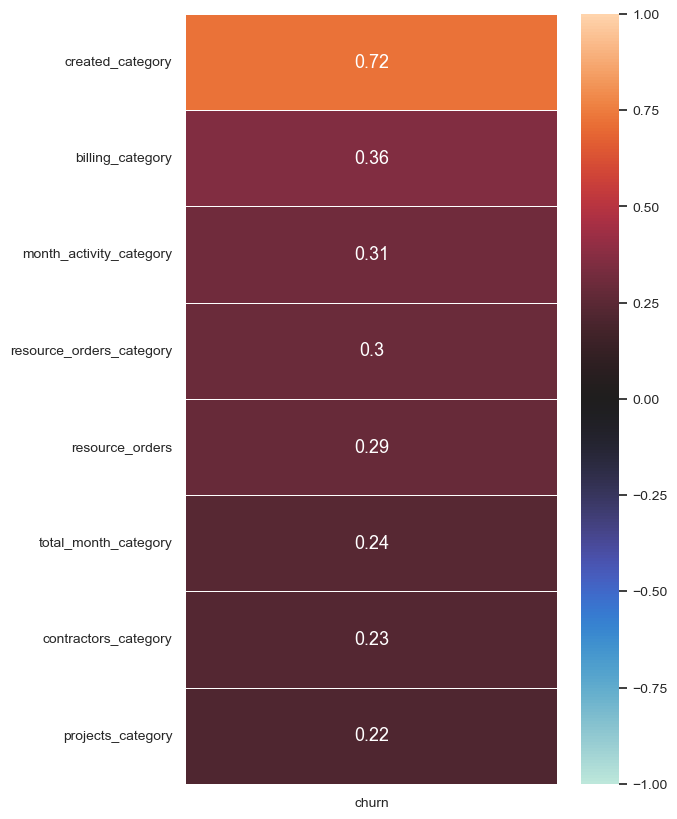

In [153]:
correlations(total_data.drop(['company_id'], axis = 1), phik = True, lim = 0.2);

А также матрицу корреляции при помощи библиотеки phik

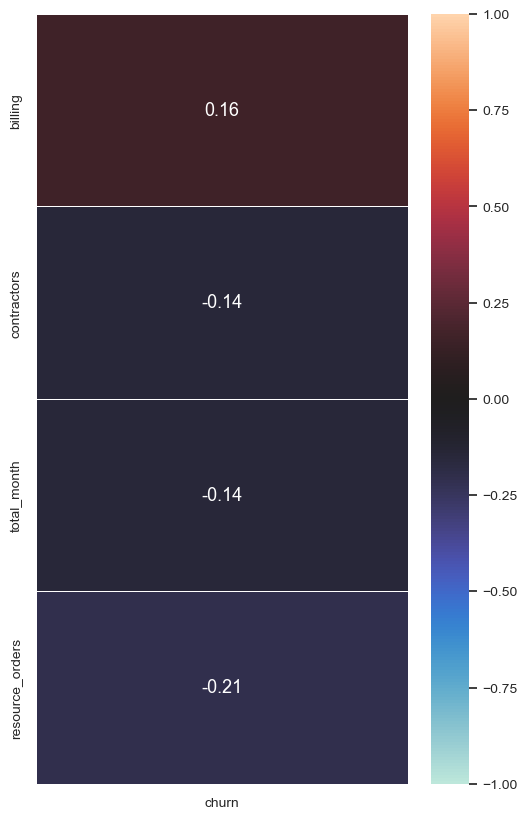

In [154]:
correlations(total_data[['churn','total_month', 'billing','stocks', 'backups', 'projects', 
                         'contractors', 'resource_orders', 'month_act_ratio']],  phik = False, lim = 0.1)

Кореляционный анализ c использованием 2 методов показал схожие результаты:
1. Анализ с использованием библиотеки phik выявил наибольшую зависимость оттока клиентов от следующих факторов:
   * Дата регистрации - наибольшему оттоку подвержены пользователи, зарегистрированные до 1.02.2022.
   * ID cтоимости тарифа - наиболее подвержены оттоку клиенты с ID cтоимости тарифа от 1 до 23.
   * Количество счетов, выставленных в приложении, компанией за месяц - наиболее подвержены компании, выставляющие в среднем более 0,5 счетов в месяц.
   * Количество месяцев активности -  наиболее подвержены компании, проявивлявшие активнось менее 7 месяцев.
   * Месячное количество заказов материалов компании -  в среднем у отточных компаний материалы заказывают реже.
   * Длительность пользования сервисом - в среднем отточные компании пользуются сервисом меньше.
   * Месячное количество контрагентов компании -  в среднем отточные компании имеют меньше контрагентов.
   * Средняя активность компаний - в среднем отточные компании проявляют активность реже.
     
2. Корреляция Пирсона выявила, что наиболее коррелируют с оттоком клиентов:
    * Количество счетов, выставленных компанией в приложении - отточные компании в среднем выставляли больше счетов в приложении.
    * Месячное количество контрагентов компании - отрицательная корреляция, в среднем отточные компании имеют меньше контрагентов.
    * Длительность пользования сервисом, - отрицательная корреляция,в среднем отточные компании пользуются сервисом меньше.
    * Месячное количество заказов материалов компании - отрицательная корреляция , в среднем у отточных компаний материалы заказывают реже.

### Проверка статистических гипотез

Проверим статистически различия между ушедшими и действующими клиентами по параметрам активности.
Так как параметры имеют большоек количество выбросов, используем критерий Манна-Уитни.

In [155]:
events = {'billing': 'Среднемесячное количество счетов, выставленных за месяц компанией',
          'stocks': 'Среднемесячное количество складов, используемых компанией',
          'backups': 'Среднемесячное количество бэкапов у компании',
          'projects': 'Среднемесячное количество проектов у компании',
          'contractors': 'Среднемесячное количество контрагентов у компании',
         'total_month': 'Длительность пользования сервисом'}

n = 1
for i in events.keys():
    print(f'{n}) ', end = ' ')
    print('Гипотезы:',
          f'H_0: {events[i]} из числа ушедших = {events[i]} из числа действующих',
          f'H_1: {events[i]} из числа ушедших ≠  {events[i]} из числа действующих',
          sep = '\n')
    alpha = 0.05/(6-n+1) #поправка к множественному сравнению методом Холма
    results = st.mannwhitneyu(activities.query('churn')[i]
                              , activities.query('not churn')[i])
    print('p-value:', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')
    n+=1   
    print()

1)  Гипотезы:
H_0: Среднемесячное количество счетов, выставленных за месяц компанией из числа ушедших = Среднемесячное количество счетов, выставленных за месяц компанией из числа действующих
H_1: Среднемесячное количество счетов, выставленных за месяц компанией из числа ушедших ≠  Среднемесячное количество счетов, выставленных за месяц компанией из числа действующих
p-value: 1.277669798664545e-20
Отвергаем нулевую гипотезу

2)  Гипотезы:
H_0: Среднемесячное количество складов, используемых компанией из числа ушедших = Среднемесячное количество складов, используемых компанией из числа действующих
H_1: Среднемесячное количество складов, используемых компанией из числа ушедших ≠  Среднемесячное количество складов, используемых компанией из числа действующих
p-value: 1.3459014801822488e-18
Отвергаем нулевую гипотезу

3)  Гипотезы:
H_0: Среднемесячное количество бэкапов у компании из числа ушедших = Среднемесячное количество бэкапов у компании из числа действующих
H_1: Среднемесячное количе

**Вывод:** Статистически отточные и неотточные компании различаются по всем показателям деятельности.

## Общие выводы и рекомендации для заказчика

В ходе проведения исследования были подгружены данные, проведена их предобработка, изучена корректность представленной информации.

В ходе изучения и предобработки загруженных данных в них были выявлены следующие проблемы:
1. Большое количества пропусков, прочерков, орфографических ошибок, а также различных вариантов написания в информации о сфере деятельности компании, что крайне затрудняет возможность использование данной информации при проведении анализа.
2. Некорректность данных в информации о дате оплаты подписки в Файле платежей. А именно заполненная дата платежа по подпискам, имеющим статус «не оплачена», и отсутствие данных о дате платежа в оплаченных подписках.
3. Присутствие информации об активности компаний вне действия оплаченных подписок. Что предполагает либо сохранение доступа компаниям все подписок, либо некорректность информации о оплате подписок, что затрудняет проведение анализа.
4. Присвоение идентичных ID пользователей как в рамках одной компании, на замену удаленному пользователю, так и действующим сотрудникам разных компаний.
5. Большое количество уникальных значений в информации о ролях сотрудников компаний, имеющих доступ к сервису, а также наличие в данных только одной роли, которая по всей видимости является ролью с базовым функционалом, присутствующей более чем в одной компании. Что делает невозможным проведение анализа оттока компаний в зависимости от ролей, используемых при работе с сервисом.
6.  Отсутствие информации о стоимости подписок делает невозможным проведение корректного анализа зависимости оттока от стоимости подписки на сервис.

На основе наличия подписки, действующей на текущий момент определены категории действующих и ушедших клиентов. Также действующими клиентами определены компании, активные в 2024 году, подписка которых истекла в марте 2024 года, и компании, имеющие неоплаченные подписки, сформированные в 2024 году.

При средней доле оттока в целом по данным в 66%, определены следующие наиболее крупные сегменты пользователей, имеющие высокий уровень оттока:
* Компании, зарегистрированные в сервисе до марта 2022 года - 85%.
* Компании, выставляющие в среднем более 0,5 счетов в месяц - 81%.
* Компании, проявляющие активность менее 7 месяцев- 75,7%.
* Компании, в среднем реализующие менее 3 проектов в месяц -  73%.
* Компании, среднемесячная активность которых менее 0,7 -  72,5%.
* Компании, в среднем использующие менее 4 складов месяц - 71%.
* Компании, в среднем имеющие менее 8 контрагентов в месяц - 70%.
* Компании, в среднем имеющие заказов материалов в месяц - 70%.
* Компании, пользующиеся сервисом менее 20 месяцев - 70%.
* Компании, среднее количество бэкапов которых составляет менее 0,7  - 68%.
* Компании с численностью сотрудников до 4 человек – 67,8%.
* Пользователей группы тарифов "Смарт" -  74%, "Базовый" -  63%.

Значения практически всех параметров активности пользователей между отточными и неотточными клиентами существенно различаются, что нашло свое подтверждение в рамках проверки статистических гипотез.


Рекомендации заказчику в части улучшения качества данных:
1. Унифицировать варианты внесения информацию в столбце с сферой деятельности компаний. 
2. Уточнить корректность внесения информации в столбец с датой оплаты и его взаимосвязь с статусом оплаты.
3. Уточнить корректность внесения информации в данные об активности клиентов.
4. Уточнить корректность формирования ID пользователей, для исключения возникновения пропущенных значений и дубликатов.
5. Унифицировать и уменьшить количество возможных ролей при доступе к сервису, что сделает более понятным разницу в функционале между ролями, и упростит понимание клиента о необходимых ролях.



Рекомендации в части уменьшения доли отточных клиентов сервиса:  
1.	Принять меры в части удержания новых пользователей. Предусмотреть сбор обратной связи по функцисервиса. Предусмотреть активнуюстеме, техническую поддержку новыых пользов, а также программы лояльности новых пользователей.
2.	Отслеживать показатели активности пользователей, с целью отслеживания потенциально отточных клиентов и принятия мер по их удержанию.
